# <font color="#114b98">Phase 2 : Problème de ML sur des données réelles d'Open Food Fact</font>


Nous allons dans un premier temps **traiter le jeu de données afin de repérer des variables pertinentes** pour les traitements à venir et **automatiser ces traitements** pour éviter de répéter ces opérations.

## <font color="#00afe6">Sommaire</font>
[1.1. Colonnes et lignes vides / Doublons](#section_1)     
[1.2. Variables redondantes](#section_2)     
[1.3. Les pays de l'analyse](#section_3)     
[1.4. Les catégories de produits](#section_4)          
[1.5. Compléter les valeurs manquantes ou aberrantes](#section_5)     
[1.6. Calcul des Nutri-Scores manquants](#section_6)     

## <font color="#00afe6">1. Nettoyage des données</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Le jeu de données téléchargé en CSV sur le site [Open Food Facts](https://world.openfoodfacts.org/) est importé dans le Notebook via la méthode `read_csv` de la librairie `pandas`

In [5]:
from data_loader import read_config, get_data

data = get_data(file_path = "../data/df_withoutduplicatefeatures4.csv")
print(f"data set shape is {data.shape}") 

Reading dataset ...
data set shape is (2830755, 165)


In [6]:
datas = data

In [7]:
print ("Le dataset compte {} lignes et {} variables".format(datas.shape[0], datas.shape[1]))

Le dataset compte 2830755 lignes et 165 variables


### <font color="#ea1c60" id="section_1">1.1. Colonnes et lignes vides / Doublons</font>
Regardons à présent les **variables qui comptent le plus de valeurs null**:

In [8]:
def null_factor(df, tx_threshold=50):
  null_rate = ((datas.isnull().sum() / datas.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  high_null_rate = null_rate[null_rate.Taux_de_Null >= tx_threshold]
  return high_null_rate

In [9]:
full_null_rate = null_factor(datas, 100)
full_null_rate

Empty DataFrame
Columns: [Variable, Taux_de_Null]
Index: []

Il n'y a pas de variable n'ayant que des valeurs null.<br>
Nous allons regarder le taux de remplissage des variables graphiquement et fixer un **seuil de suppression à 25% de taux de remplissage** :

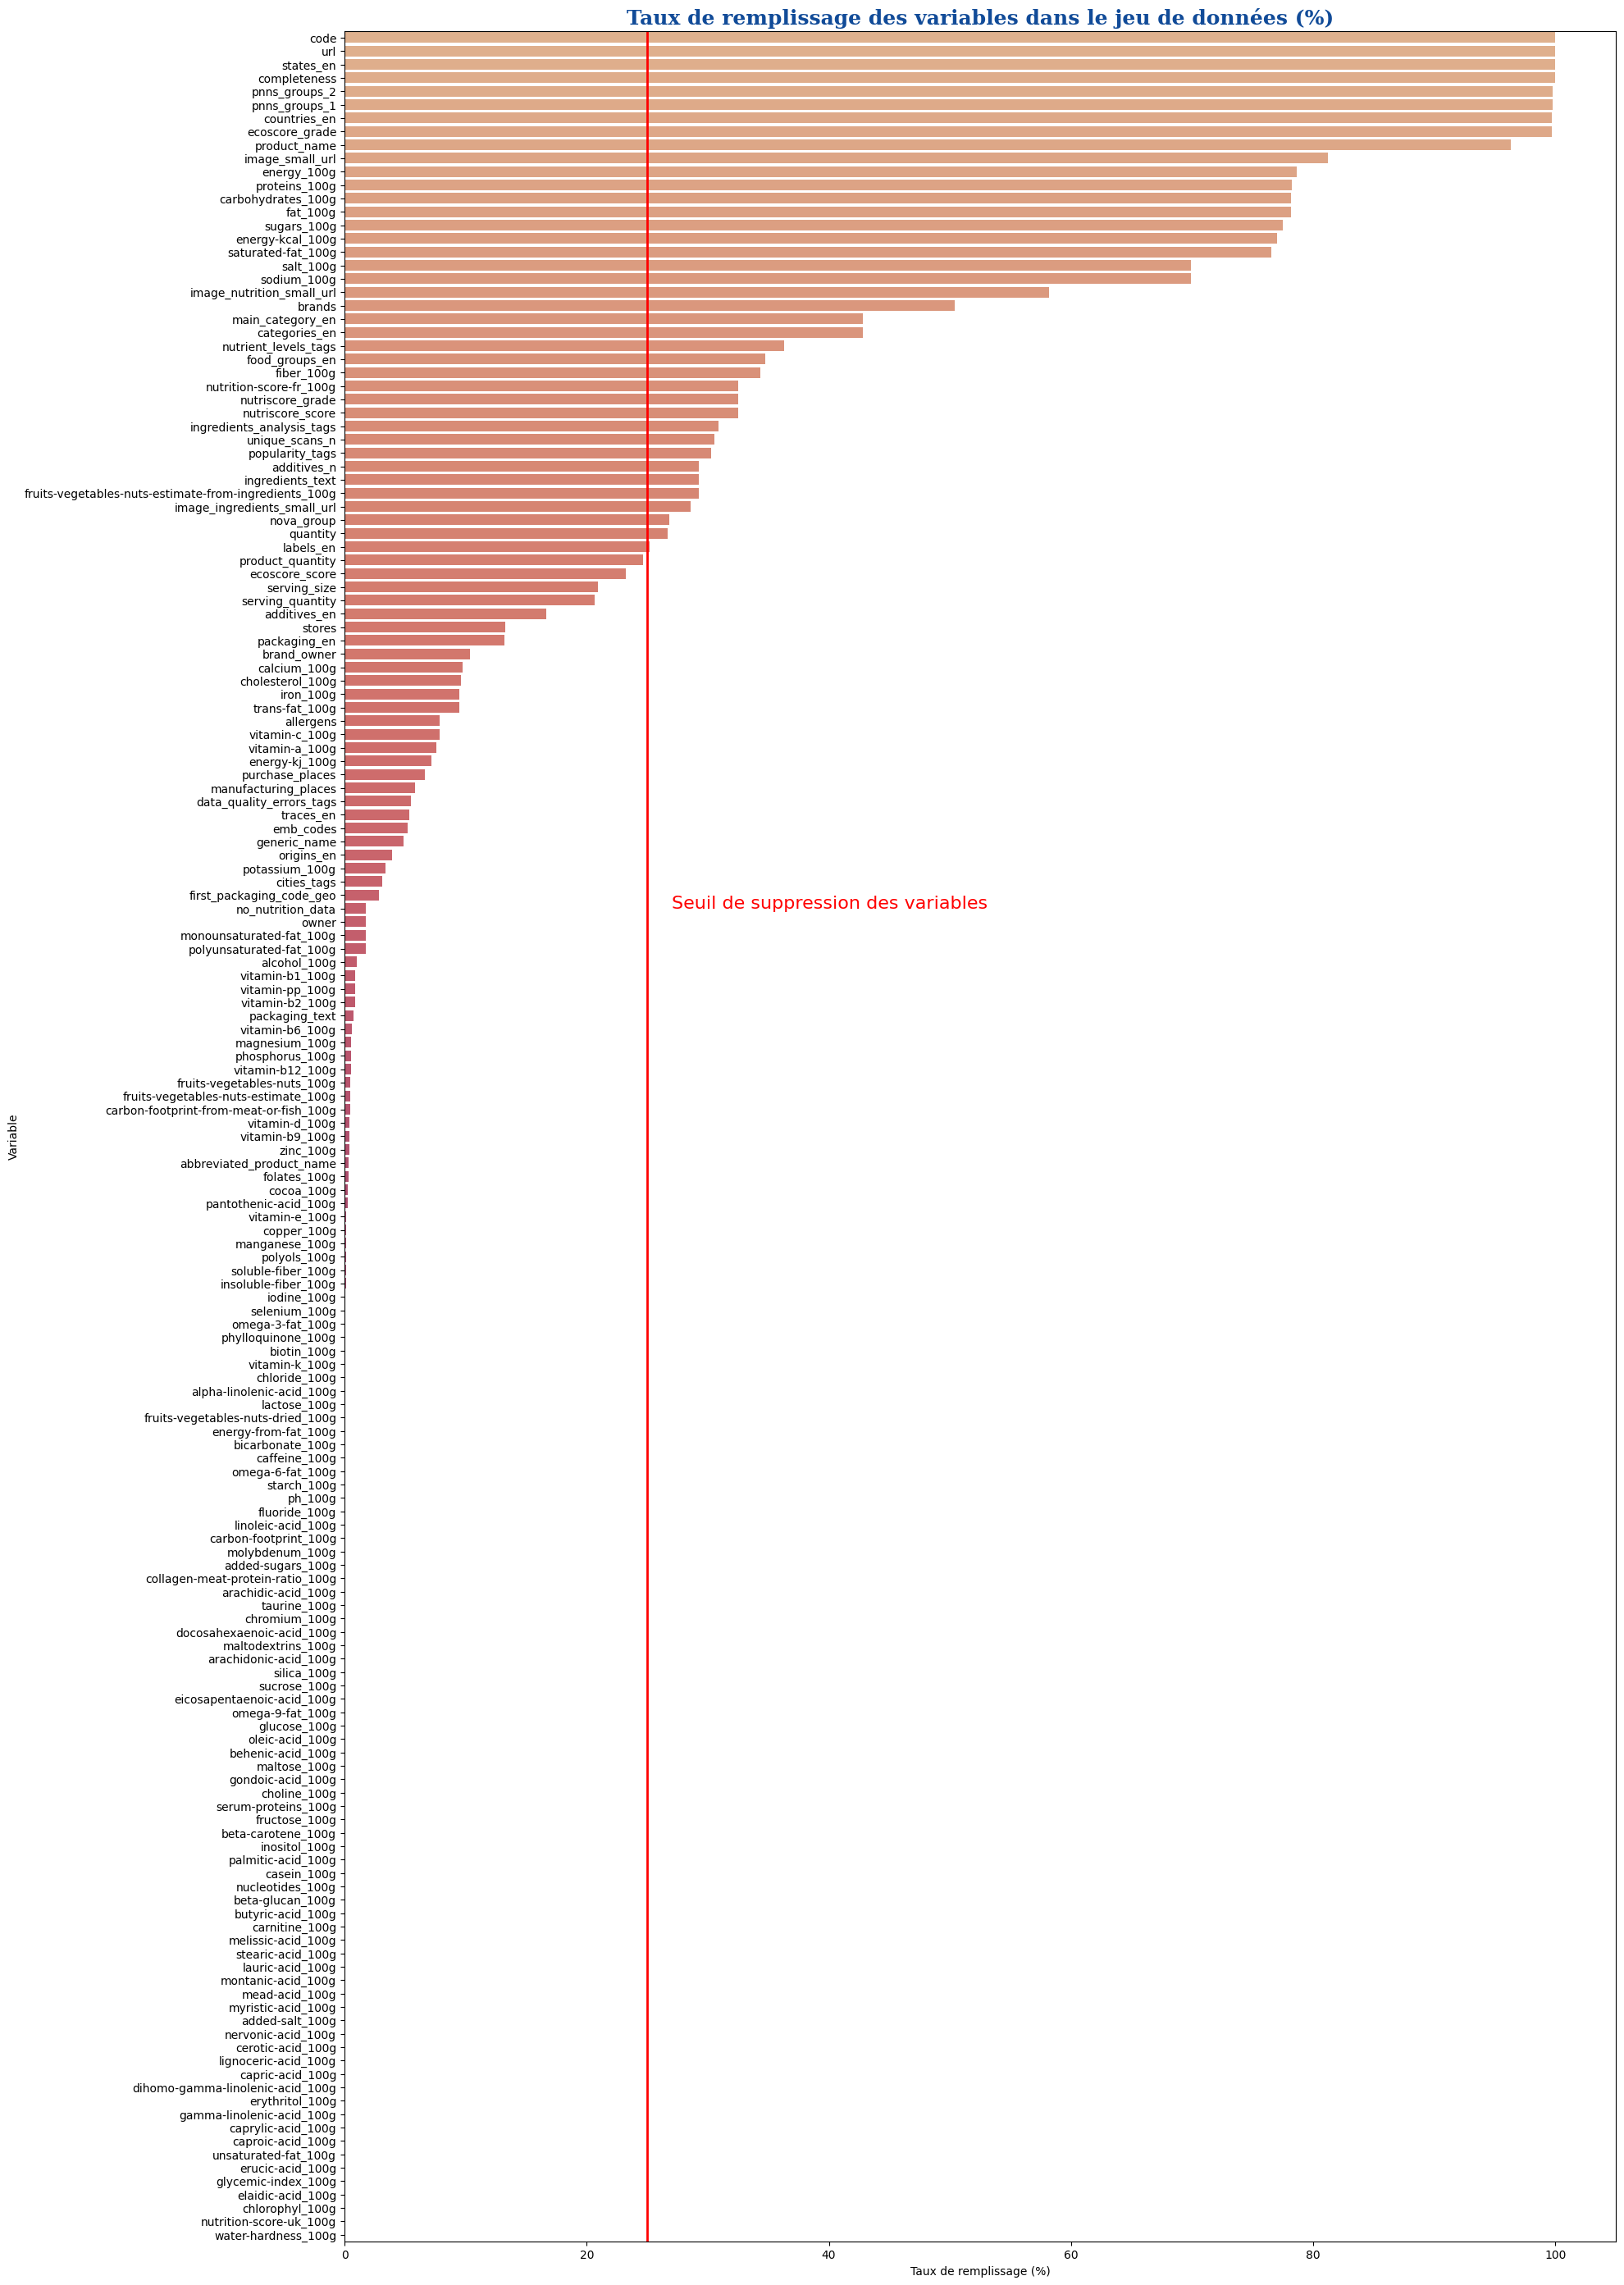

In [10]:
filling_features = null_factor(datas, 0)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 25

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

In [11]:
#Liste des variables à conserver
features_to_conserve = list(filling_features.loc[filling_features['Taux_de_Null']>=sup_threshold, 'Variable'].values)
#Liste des variables supprimées
deleted_features = list(filling_features.loc[filling_features['Taux_de_Null']<sup_threshold, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
#datas = datas[features_to_conserve].sort_values(["created_datetime","last_modified_datetime"], ascending=True)
#datas.sample(5)

De nombreuses features ont un taux de valeurs nulles supérieur à 50%, ce qui représente une très grosse part de données manquantes. **La majeure partie de ces variables ne peuvent pas être recalculées** puisqu'il s'agit de mesures physico-chimiques directes sur les produits. Pour le moment nous allons tous les garder, nous les supprimerons plus tard.

Pour la suite des analyses, nous aurons besoin d'un minimum d'informations sur **les nutriments** des produits. Ces données sont **suffixées avec** `_100g`. Nous allons donc **conserver les lignes pour lesquelles au moins une de ces features est complétée** :

In [12]:
def search_componant(df, suffix='_100g'):
  componant = []
  for col in df.columns:
      if '_100g' in col: componant.append(col)
  df_subset_columns = df[componant]
  return df_subset_columns

In [13]:
df_subset_nutients = search_componant(datas,'_100g')
df_subset_nutients.head()

energy-kj_100g  energy-kcal_100g  energy_100g  energy-from-fat_100g   
0             NaN               NaN          NaN                   NaN  \
1             NaN             165.0        690.0                   NaN   
2             NaN               NaN          NaN                   NaN   
3             NaN              57.0        238.0                   NaN   
4             NaN             375.0       1569.0                   NaN   

   fat_100g  saturated-fat_100g  butyric-acid_100g  caproic-acid_100g   
0       NaN                 NaN                NaN                NaN  \
1       2.0                2.00                NaN                NaN   
2       1.4                0.90                NaN                NaN   
3       0.2                0.10                NaN                NaN   
4       7.0                3.08                NaN                NaN   

   caprylic-acid_100g  capric-acid_100g  ...   
0                 NaN               NaN  ...  \
1                 NaN               NaN  ...   
2                 NaN               NaN  ...   
3                 NaN               NaN  ...   
4                 NaN               NaN  ...   

   carbon-footprint-from-meat-or-fish_100g  nutrition-score-fr_100g   
0                                      NaN                      NaN  \
1                                      NaN                      NaN   
2                                      NaN                      NaN   
3                                      NaN                     -5.0   
4                                      NaN                      NaN   

   nutrition-score-uk_100g  glycemic-index_100g  water-hardness_100g   
0                      NaN                  NaN                  NaN  \
1                      NaN                  NaN                  NaN   
2                      NaN                  NaN                  NaN   
3                      NaN                  NaN                  NaN   
4                      NaN                  NaN                  NaN   

   choline_100g  phylloquinone_100g  beta-glucan_100g  inositol_100g   
0           NaN                 NaN               NaN            NaN  \
1           NaN                 NaN               NaN            NaN   
2           NaN                 NaN               NaN            NaN   
3           NaN                 NaN               NaN            NaN   
4           NaN                 NaN               NaN            NaN   

   carnitine_100g  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  

[5 rows x 116 columns]

In [14]:
print('Lignes nutriments (_100g) vides: {}'.format(df_subset_nutients.isnull().all(axis=1).sum()))

Lignes nutriments (_100g) vides: 474355


In [15]:
datas = datas[df_subset_nutients.notnull().any(axis=1)]
datas.shape

(2356400, 165)

Notre jeu de données est à présent débarassé des lignes (et colonnes) peu complétées. Nous allons à présent **rechercher et supprimer les doublons**.

In [16]:
# Suppression des doublons en fonction du code
datas.drop_duplicates(subset ="code", keep = 'last', inplace=True)

C:\Users\joell\AppData\Local\Temp\ipykernel_17812\2235139470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datas.drop_duplicates(subset ="code", keep = 'last', inplace=True)


In [17]:
datas[(datas["product_name"].isnull()==False) 
      & (datas["brands"].isnull()==False)].groupby(by=["product_name","brands"])["code"].nunique().sort_values(ascending=False)

product_name                 brands                 
Burger vegetariana           Bonarea                    305
Filet de poulet              La Nouvelle Agriculture    218
Burger vegana                Bonarea                    205
Finísimo de pechuga de pavo  Bonarea                    155
Filet de poulet              Le Gaulois                 146
                                                       ... 
Galette frangipane           Cora                         1
                             Leader Price                 1
                             Match                        1
                             Monoprix                     1
🤬                            🤬                            1
Name: code, Length: 1133879, dtype: int64

In [18]:
datas = datas[(datas["product_name"]!="🤬") 
              & (datas["brands"]!="🤬")]

In [19]:
# Suppression des doublons sur marque et produit en conservant les valeurs nulles
datas = datas[(~datas.duplicated(["product_name","brands"],keep="last")) 
      | ((datas['product_name'].isnull()) & (datas['brands'].isnull()))]

In [20]:
datas.shape

(1877499, 165)

### <font color="#ea1c60" id="section_2">1.2. Variables redondantes ou utiles</font>

Certaines variables dans le dataset sont en réalité des variables redondantes ou pas très pertinentes pour nos analyses. Nous les avons donc supprimé manuellement au préalable. 

C'est par exemple le cas des **variables suffixées par `_tags` ou `_en`** qui ne font que reprendre d'autres features traduites ou simplifiées. Nous avons donc, lorsque la colonne suffixée `_en` existe, supprimer toutes les autres colonnes identiques non suffixées ou contenant `_tags`.

D'autres variables sont également redondantes, comme celles avec les images.

Les variables telles que les dates et noms de contributeurs ont été aussi supprimées car elles ne sont qu'informatives mais pas utiles.

A présent, notre dataset des variables qui ne contienent plus de redondance. Nous allons maintenant nous intéresser à une variable importante : le pays.

### <font color="#ea1c60" id="section_3">1.3. Les pays de l'analyse</font>

Regardons tout d'abord le nombre de pays représentés *(s'il est trop élevé, c'est que des erreurs existent)*

In [22]:
countries = datas.groupby(by="countries_en").nunique()

In [23]:
countries[['code']].head()

code
countries_en                           
123456789                             1
Afghanistan                          15
Afghanistan,Belgium,France            2
Afghanistan,Finland,France,Sweden     1
Afghanistan,France                  115

Plusieurs pays sont regroupés dans la même variable, nous allons devoir effectuer un split du texte pour visualiser tout nos pays :

In [24]:
def split_words(df, column = 'countries_en'):
  list_words = set()
  for word in df[column].str.split(','):
    if isinstance(word, float):
      continue
    list_words = set().union(word, list_words)
  return list(list_words)

In [25]:
#Liste contenant tous les pays du jeu de données (bons ou mauvais)
list_countries = split_words(datas, 'countries_en')

In [26]:
print("Nombre de pays représentés : {}".format(len(list_countries)))

Nombre de pays représentés : 882


Nous allons charger une **base de données des pays, en Anglais**, pour déterminer les pays qui ne matchent pas *(mauvaise orthographe ou autre)*.

In [27]:
df_countries = pd.read_csv("../data/countries-en.csv",
                        sep=",", header=None, index_col = 0).rename(columns={0:"index", 1:"country_id", 2:"country_code_2", 3:"country_code_3", 4:"country_fr", 5:"country_en"})
df_countries.head()

country_id country_code_2 country_code_3         country_fr      country_en
0                                                                             
1           4             AF            AFG        Afghanistan     Afghanistan
2           8             AL            ALB            Albanie         Albania
3          10             AQ            ATA        Antarctique      Antarctica
4          12             DZ            DZA            Algérie         Algeria
5          16             AS            ASM  Samoa Américaines  American Samoa

In [28]:
df_countries = pd.merge(pd.DataFrame(list_countries, columns=["countries_dataset"]),df_countries, how="left", 
         left_on="countries_dataset", right_on="country_en")

In [29]:
false_country_list = list(df_countries[df_countries.isnull().sum(axis=1)>0].countries_dataset)
false_country_list[0:15]

['Azerbaidjan',
 'P-p-19',
 'Kolkata',
 'Dinamarca',
 'Spagna',
 'France-italy',
 'ירח',
 'Беларусь',
 'de:de-en-germany',
 'France-brazil',
 'Badajoz',
 'sv:españa-suecia',
 'sr:crna-gora',
 'Weissrussland',
 'Portogallo']

puis nous allons **supprimer ces pays "fantômes" de la base de données** :

In [30]:
for index, countries in datas['countries_en'].str.split(',').items():
  if isinstance(countries, float):
    continue
  country_name = []
  found = False
  for country in countries:
    if country in false_country_list:
      found = True
    else:
      country_name.append(country)
  if found:
    datas.loc[index, 'countries_en'] = ','.join(country_name)

In [31]:
print("Nouveau nombre de pays représentés : {}".format(len(split_words(datas, 'countries_en'))))

Nouveau nombre de pays représentés : 199


Le nombre de pays représenté est à présent plus cohérent et la perte d'informations est limitée. Il nous reste à présent à **compléter les valeurs nulles pour cette variable**.

In [32]:
datas['countries_en'] = np.where((datas['countries_en'].isnull()==True), "unknown", 
                                 np.where(datas['countries_en'] == "", "unknown", datas['countries_en']))

Nous pouvons également regarder quels sont les **pays les plus représentés** :

In [35]:
def top_words(df, column="countries_en", nb_top=10):
    count_keyword = dict()
    df_col = df[column].to_frame(name=column)
    for index, col in df_col.iterrows():
        if isinstance(col[column], float):
            continue
        for word in col[column].split(','):
            if word in count_keyword.keys():
                count_keyword[word] += 1
            else:
                count_keyword[word] = 1

    keyword_top = []
    for k,v in count_keyword.items():
        keyword_top.append([k,v])
    keyword_top.sort(key = lambda x:x[1], reverse = True)

    return keyword_top[:nb_top]

In [36]:
df_top_countries = pd.DataFrame(top_words(df=datas, column="countries_en", nb_top=10), 
                                columns=["Keyword","count"])
df_top_countries

Keyword   count
0          France  636363
1   United States  433779
2           Spain  184323
3           Italy  146167
4         Germany  127362
5  United Kingdom   65551
6     Switzerland   63312
7         Belgium   55700
8          Canada   51256
9         Ireland   28762

**La France et les Etats-Unis sont massivement représentés** dans le Dataset.

### <font color="#ea1c60" id="section_4">1.4. Les catégories de produits</font>

Intéressons nous à présent à la catégorisation des produits. 5 variables représentent cette catégorisation de manière plus ou moins précise : `categories_en`, `main_category_en`, `pnns_groups_1`, `pnns_groups_2`,`food_groups_en`.

In [41]:
datas[['categories_en','pnns_groups_1','pnns_groups_2','main_category_en','food_groups_en']].sample(10)

categories_en   
650584                                                 NaN  \
1097555  Plant-based foods and beverages,Plant-based fo...   
2707194  Snacks,Sweet snacks,Confectioneries,Candies,Li...   
589794                                              Snacks   
1951629  Plant-based foods and beverages,Plant-based fo...   
846015   Meats and their products,Meals,Meals with meat...   
2777356                                                NaN   
404606                                                 NaN   
2597349                                                NaN   
1345540  Snacks,Sweet snacks,Biscuits and cakes,Gingerb...   

                pnns_groups_1             pnns_groups_2   
650584                unknown                   unknown  \
1097555          Salty snacks  Salty and fatty products   
2707194         Sugary snacks                    Sweets   
589794                unknown                   unknown   
1951629  Cereals and potatoes                   Legumes   
846015        Composite foods            One-dish meals   
2777356               unknown                   unknown   
404606                unknown                   unknown   
2597349               unknown                   unknown   
1345540         Sugary snacks        Biscuits and cakes   

                           main_category_en   
650584                                  NaN  \
1097555                   Plant-based pâtés   
2707194                   Liquorice candies   
589794                               Snacks   
1951629  fr:melanges-de-legumes-en-conserve   
846015                      Microwave meals   
2777356                                 NaN   
404606                                  NaN   
2597349                                 NaN   
1345540                        Gingerbreads   

                                food_groups_en  
650584                                     NaN  
1097555  Salty snacks,Salty and fatty products  
2707194                   Sugary snacks,Sweets  
589794                                     NaN  
1951629           Cereals and potatoes,Legumes  
846015          Composite foods,One-dish meals  
2777356                                    NaN  
404606                                     NaN  
2597349                                    NaN  
1345540       Sugary snacks,Biscuits and cakes

Nous allons regarder le **nombre total de catégories représentées** :

In [42]:
categories = split_words(df = datas, column = 'categories_en')
print("{} catégories sont représentées dans le jeu de données.".format(len(categories)))

42622 catégories sont représentées dans le jeu de données.


Ici également, nous allons regarder les **catégories les plus représentées**, après avoir remplacé les valeurs nulles et complété les valeurs inconnues des pnns avec la catégorie principale :

In [43]:
datas['categories_en'] = np.where((datas['categories_en'].isnull()==True), "unknown", 
                                 np.where(datas['categories_en'] == "", "unknown", datas['categories_en']))
datas['main_category_en'] = np.where((datas['main_category_en'].isnull()==True), "unknown", 
                                 np.where(datas['main_category_en'] == "", "unknown", datas['main_category_en']))
datas['pnns_groups_1'] = np.where((datas['pnns_groups_1'].isnull()==True), "unknown", 
                                 np.where(datas['pnns_groups_1'] == "", "unknown", datas['pnns_groups_1']))
datas['pnns_groups_2'] = np.where((datas['pnns_groups_2'].isnull()==True), "unknown", 
                                 np.where(datas['pnns_groups_2'] == "", "unknown", datas['pnns_groups_2']))
datas['food_groups_en'] = np.where((datas['food_groups_en'].isnull()==True), "unknown", 
                                 np.where(datas['food_groups_en'] == "", "unknown", datas['food_groups_en']))

In [44]:
df_top_categories = pd.DataFrame(top_words(df=datas, column="categories_en", nb_top=10), 
                                 columns=["Keyword","count"])
df_top_categories

Keyword   count
0                          unknown  965781
1  Plant-based foods and beverages  286630
2                Plant-based foods  245248
3                           Snacks  187124
4                     Sweet snacks  135597
5                        Beverages  103170
6             Cereals and potatoes   92123
7                          Dairies   89366
8         Meats and their products   72121
9                  Fermented foods   69412

Il existe donc également une grande disparité dans les catégories représentées et les "unknown", les catégories inconnues l'emportent. 

Pour une meilleure visualisation, nous allons représenter le top 100 des catégories dans un nuage de mots grâce à la librairie `WordCloud` :

In [45]:
from wordcloud import WordCloud

def plot_world_cloud(df=datas,column="categories_en",nb_top=100):
  fig = plt.figure(1, figsize=(20,15))
  ax1 = fig.add_subplot(1,1,1)

  words = dict()
  trunc_occurences = top_words(df=df, column=column, nb_top=nb_top)
  for s in trunc_occurences:
    words[s[0]] = s[1]

  word_cloud = WordCloud(width=900,height=500, normalize_plurals=False,
                        background_color="white")
  word_cloud.generate_from_frequencies(words)
  ax1.imshow(word_cloud, interpolation="bilinear")
  ax1.axis('off')
  plt.title("Nuage de mots des {} meilleures {}\n".format(nb_top, column), fontsize=22)
  plt.show()

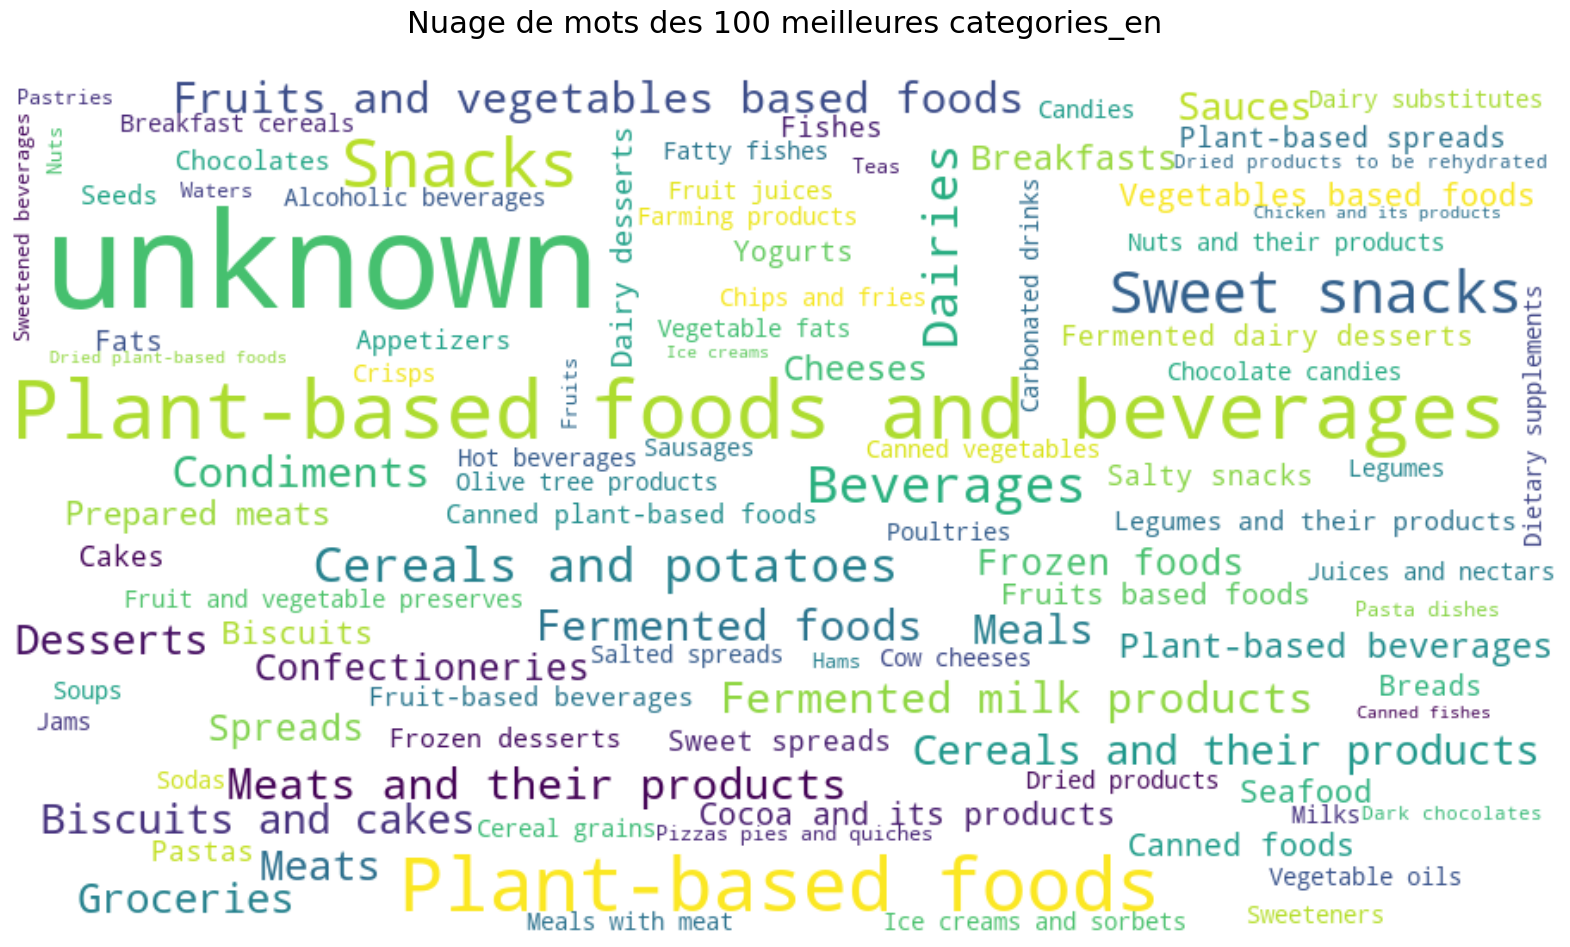

In [46]:
plot_world_cloud(df=datas,column="categories_en",nb_top=100)

Passons à présent aux variables `pnns_groups_1` et `pnns_groups_2` qui nous apporteront des informations plus précises :

In [47]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

12 catégories sont représentées dans la variable pnns_group_1.
41 catégories sont représentées dans la variable pnns_group_2.


In [48]:
pnns_groups_1

['Fish Meat Eggs',
 'Fat and sauces',
 'unknown',
 'Composite foods',
 'Fruits and vegetables',
 'Alcoholic beverages',
 'Beverages',
 'Salty snacks',
 'Cereals and potatoes',
 'sugary-snacks',
 'Sugary snacks',
 'Milk and dairy products']

On voit ici que des catégories peuvent être présentes plusieurs fois mais orthographiées différement :
- 'Sugary Snacks' et 'sugary-snacks'

Nous allons donc corriger le problème en passant le texte en minuscule et en remplaçant les caractères spéciaux par un espace :

In [49]:
datas["pnns_groups_1"] = datas["pnns_groups_1"].str.lower().str.replace('-', ' ')

In [50]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print(pnns_groups_1)

11 catégories sont représentées dans la variable pnns_group_1.
['alcoholic beverages', 'composite foods', 'beverages', 'salty snacks', 'unknown', 'fat and sauces', 'fish meat eggs', 'sugary snacks', 'milk and dairy products', 'fruits and vegetables', 'cereals and potatoes']


In [51]:
pnns_groups_2

['pastries',
 'Processed meat',
 'Sweets',
 'Fruit nectars',
 'Meat',
 'Bread',
 'Fruit juices',
 'Sweetened beverages',
 'Soups',
 'Eggs',
 'Milk and yogurt',
 'Legumes',
 'Pastries',
 'Chocolate products',
 'Vegetables',
 'Cheese',
 'Artificially sweetened beverages',
 'Ice cream',
 'Fruits',
 'Pizza pies and quiches',
 'Biscuits and cakes',
 'One-dish meals',
 'Breakfast cereals',
 'Nuts',
 'Potatoes',
 'Dairy desserts',
 'Offals',
 'Plant-based milk substitutes',
 'Dried fruits',
 'Dressings and sauces',
 'unknown',
 'Waters and flavored waters',
 'Alcoholic beverages',
 'Unsweetened beverages',
 'Teas and herbal teas and coffees',
 'Appetizers',
 'Fish and seafood',
 'Cereals',
 'Fats',
 'Sandwiches',
 'Salty and fatty products']

In [52]:
datas["pnns_groups_2"] = datas["pnns_groups_2"].str.lower().str.replace('-', ' ')
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

40 catégories sont représentées dans la variable pnns_group_2.


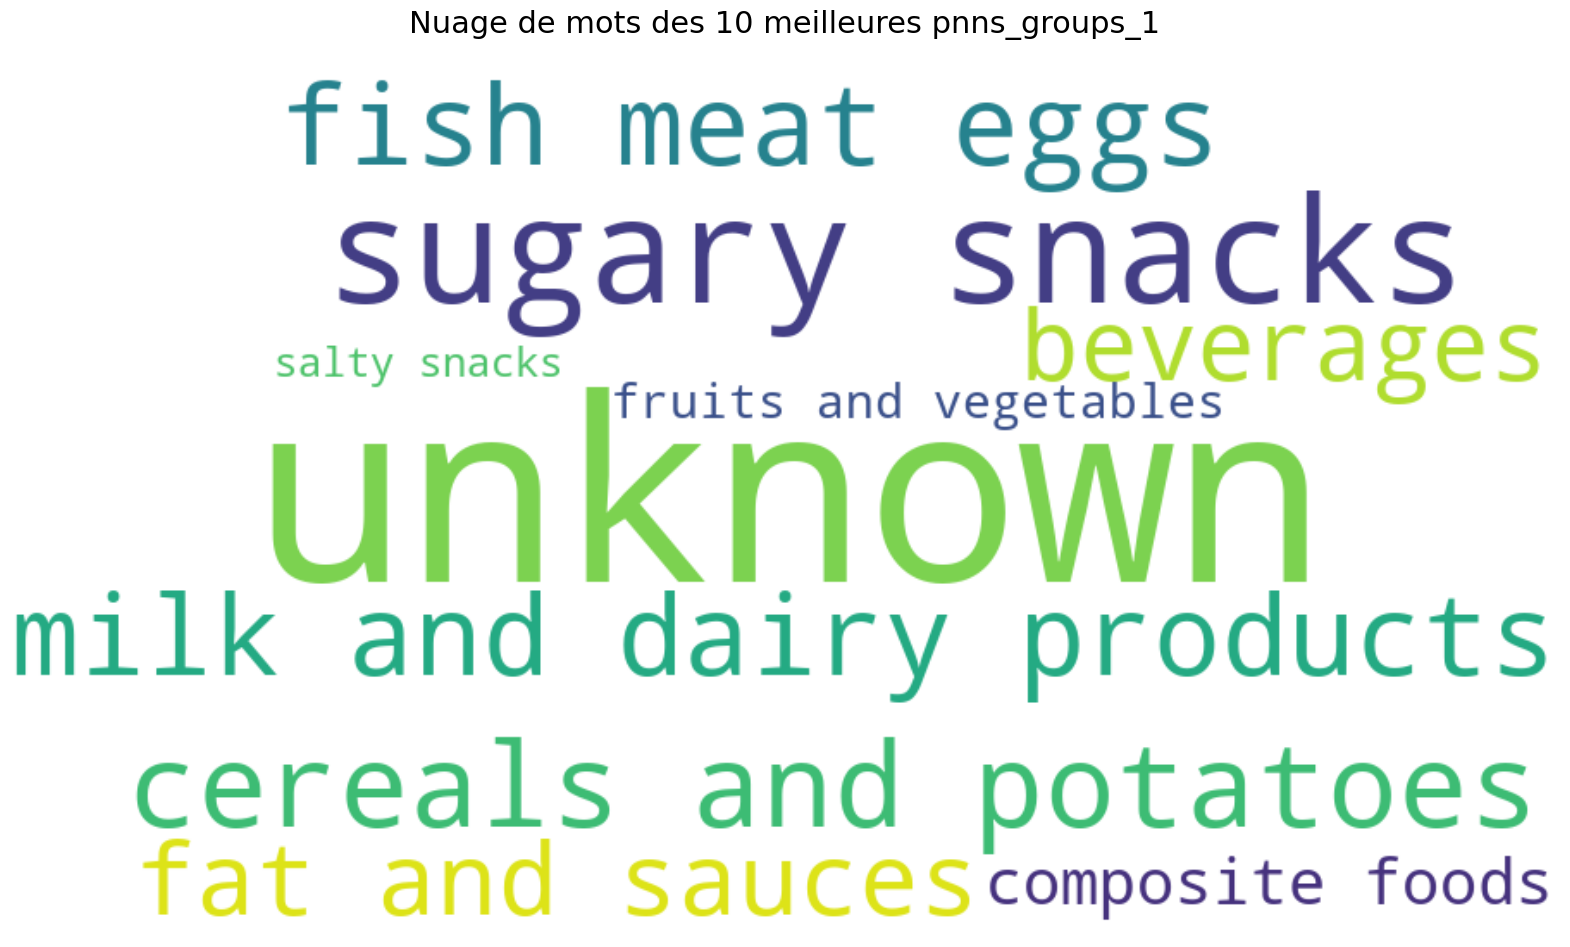

In [53]:
plot_world_cloud(df=datas,column="pnns_groups_1",nb_top=10)

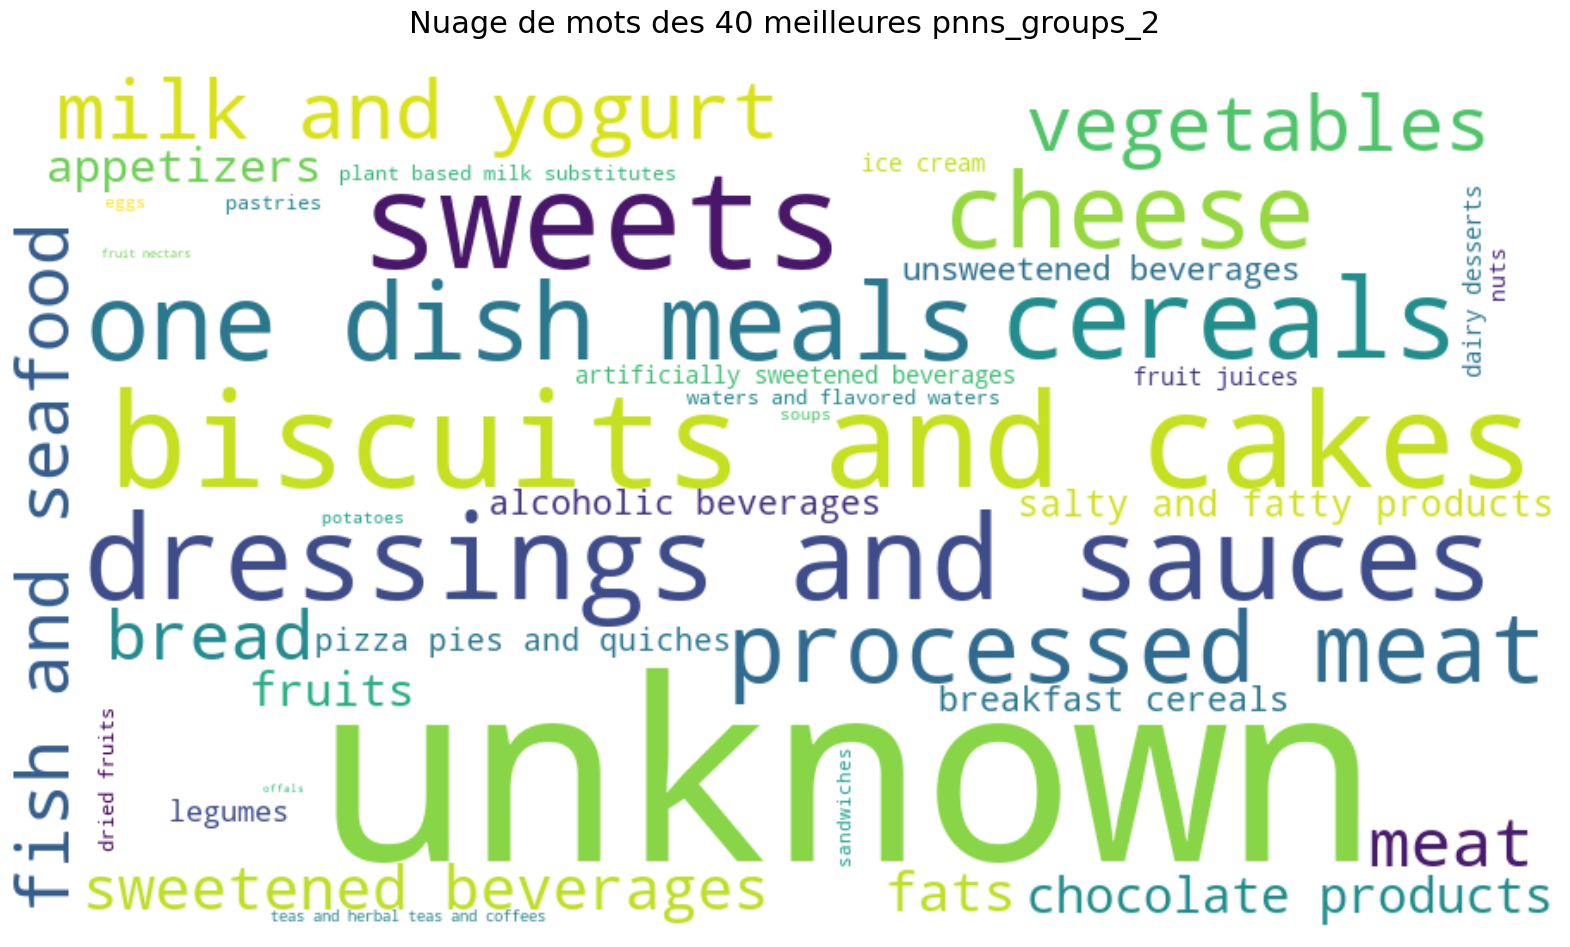

In [54]:
plot_world_cloud(df=datas,column="pnns_groups_2",nb_top=len(pnns_groups_2))

In [55]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1877499 entries, 1 to 2830754
Columns: 165 entries, code to carnitine_100g
dtypes: float64(124), object(41)
memory usage: 2.3+ GB


### <font color="#ea1c60" id="section_5">Packaging</font>

In [60]:
packaging_en = split_words(df = datas, column = 'packaging_en')
print("{} catégories sont représentées dans la variable packaging_en.".format(len(packaging_en)))

datas['packaging_en'] = np.where((datas['packaging_en'].isnull()==True), "unknown", 
                                 np.where(datas['packaging_en'] == "", "unknown", datas['packaging_en']))

20594 catégories sont représentées dans la variable packaging_en.


In [61]:
df_top_packaging = pd.DataFrame(top_words(df=datas, column="packaging_en", nb_top=10), 
                                 columns=["Keyword","count"])
df_top_packaging

Keyword    count
0    unknown  1566185
1    Plastic   114840
2  Cardboard    38037
3      Glass    29512
4        Bag    29276
5     Bottle    18697
6      Fresh    18544
7      Metal    16002
8        Box    15236
9       Tray    14293

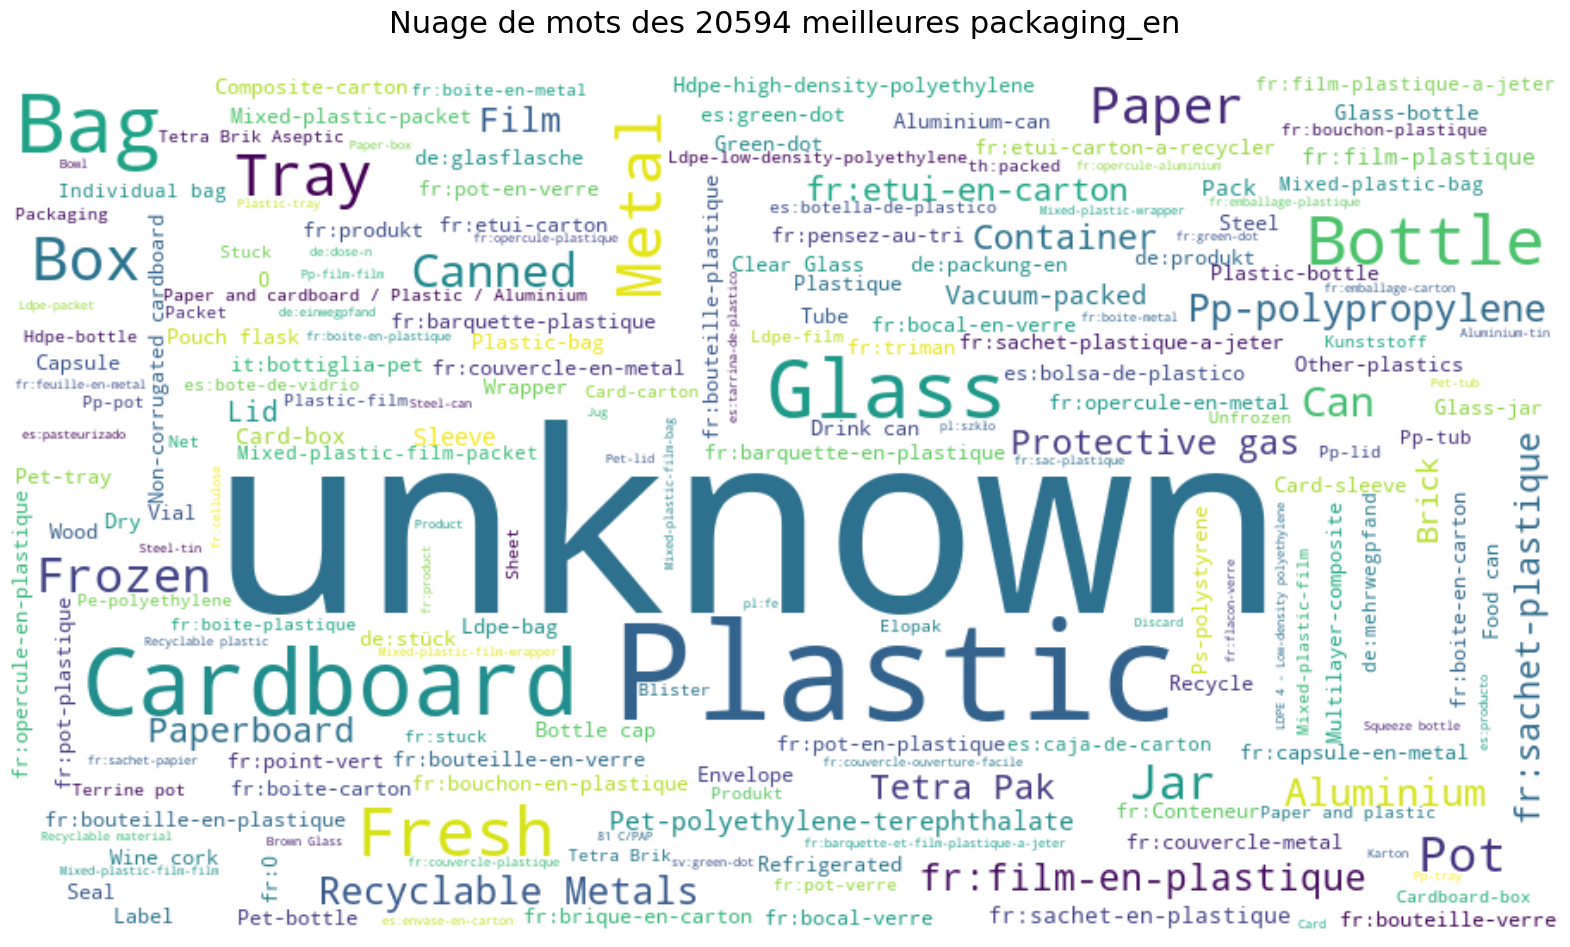

In [68]:
plot_world_cloud(df=datas,column="packaging_en",nb_top=len(packaging_en))

### <font color="#ea1c60" id="section_5">1.5. Compléter les valeurs manquantes ou aberrantes</font>

Le jeu de données est nettoyé mais comme le montre les informations ci-dessus, il reste un grand nombre de valeurs manquantes qu'il va falloir compléter mais également des outliers à identifier.

Regardons dans un premier temps une rapide description du Dataset :

In [65]:
datas.describe()

serving_quantity    additives_n  nutriscore_score     nova_group   
count      4.989590e+05  723316.000000     753230.000000  641173.000000  \
mean       2.449814e+28       1.958678          9.192364       3.391380   
std        1.730476e+31       2.827394          8.679002       0.986667   
min        0.000000e+00       0.000000        -15.000000       1.000000   
25%        2.800000e+01       0.000000          2.000000       3.000000   
50%        5.600000e+01       1.000000         10.000000       4.000000   
75%        1.180000e+02       3.000000         16.000000       4.000000   
max        1.222357e+34      50.000000         40.000000       4.000000   

       ecoscore_score  product_quantity  unique_scans_n  completeness   
count    479401.00000      5.435820e+05   649343.000000  1.877497e+06  \
mean         48.90237      1.655708e+13        2.546171  4.802570e-01   
std          25.31537      1.220703e+16        6.794489  2.018555e-01   
min         -30.00000      0.000000e+00        1.000000  1.000000e-01   
25%          30.00000      1.500000e+02        1.000000  3.000000e-01   
50%          49.00000      2.800000e+02        1.000000  4.000000e-01   
75%          72.00000      5.000000e+02        2.000000  5.750000e-01   
max         125.00000      9.000000e+18      842.000000  1.100000e+00   

       energy-kj_100g  energy-kcal_100g  ...   
count    1.871710e+05      1.723938e+06  ...  \
mean     3.644603e+03      3.043754e+39  ...   
std      1.054156e+06      3.996413e+42  ...   
min      0.000000e+00     -5.300000e+01  ...   
25%      3.930000e+02      1.000000e+02  ...   
50%      9.900000e+02      2.590000e+02  ...   
75%      1.620000e+03      4.000000e+02  ...   
max      4.555600e+08      5.247243e+45  ...   

       carbon-footprint-from-meat-or-fish_100g  nutrition-score-fr_100g   
count                             11727.000000            753233.000000  \
mean                                608.323594                 9.192389   
std                                6118.394023                 8.678998   
min                                   0.049000               -15.000000   
25%                                 102.075000                 2.000000   
50%                                 310.800000                10.000000   
75%                                 606.800000                16.000000   
max                              656298.600000                40.000000   

       nutrition-score-uk_100g  glycemic-index_100g  water-hardness_100g   
count                 3.000000             6.000000                1.000  \
mean                 18.666667            40.950000                1.475   
std                   6.027714            18.779111                  NaN   
min                  13.000000            14.000000                1.475   
25%                  15.500000            32.250000                1.475   
50%                  18.000000            41.500000                1.475   
75%                  21.500000            47.525000                1.475   
max                  25.000000            70.000000                1.475   

       choline_100g  phylloquinone_100g  beta-glucan_100g  inositol_100g   
count     96.000000         1344.000000         52.000000      80.000000  \
mean       6.891693            0.087756          3.506346       1.921747   
std       43.472295            2.061522          2.775687      11.776487   
min        0.000000            0.000000          0.400000       0.001600   
25%        0.039025            0.000008          2.275000       0.008775   
50%        0.083000            0.000024          3.600000       0.024500   
75%        0.122500            0.000103          4.000000       0.051000   
max      390.000000           54.000000         20.000000      75.000000   

       carnitine_100g  
count       46.000000  
mean         0.024343  
std          0.083090  
min          0.000800  
25%          0.007000  
50%          0.011000  
75%          0.015000  
ma

On remarque déjà que les valeurs minimum et maximum de **certaines variables** (comme les nutriments ou la valeur energetique) **peuvent contenir des valeurs aberrantes**, ce qui impacte également l'écart-type et donc la variance.

Nous allons **supprimer tous les produits qui n'ont ni nom, ni catégorie** et qui ne pourront donc être clairement identifiés.

In [69]:
datas_cleaned = datas[~((datas.product_name.isnull()) 
                        & ((datas.pnns_groups_1 == "unknown") 
                           | (datas.main_category_en == "unknown")))]

In [70]:
datas_cleaned[((datas_cleaned.pnns_groups_1 == "unknown") & (datas_cleaned.main_category_en == "unknown") &
              (datas_cleaned.pnns_groups_2 == "unknown") & (datas_cleaned.categories_en == "unknown"))].shape[0]

957513

Il reste tout de même **957513 qui ne contiennent aucune indication de catégorie**.

Afin de pouvoir calculer des indicateurs empiriques correctes, nous allons remplacer par des valeurs nulles tous les max et min aberrants *(0, -1 ou 999999...)* :

In [74]:
#On repère les numerical_features
numerical_features = list(datas_cleaned.select_dtypes(include=["float64","int64"]).columns)
#On supprime les nutriscores qui eux peuvent être négatifs
numerical_features.remove('nutriscore_score')
numerical_features.remove('nutrition-score-fr_100g')
numerical_features.remove('nutrition-score-uk_100g')
numerical_features.remove('nova_group')

In [57]:
#On supprime les lignes dont toutes les numerical_features sont à 0 ou nulles
#datas_cleaned = datas_cleaned.loc[~((datas_cleaned[numerical_features]==0) | (datas_cleaned[numerical_features].isnull())).all(axis=1)]

In [75]:
#On supprime les lignes contenant des valeurs négatives et des max aberrants
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features] < 0).any(axis=1)]
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features].isin([999999,9999999])).any(axis=1)]

Les variables suffixées avec `_100g` nous indiquent la quantité de nutriment pour 100 grammes de produit. Les valeurs renseignées ne peuvent donc logiquement pas excéder 100. Nous allons donc **supprimer les lignes dont au moins 1 des variables de nutriments est supérieur au seuil** :

In [77]:
#On repère les g_per_100g_features
g_per_100g_features = list(datas_cleaned.filter(regex='_100g$').columns)
#On supprime les features ayant des unités différentes des g
g_per_100g_features.remove('energy-kj_100g')
g_per_100g_features.remove('energy-kcal_100g')
g_per_100g_features.remove('energy_100g')
g_per_100g_features.remove('energy-from-fat_100g')
g_per_100g_features.remove('ph_100g')
g_per_100g_features.remove('carbon-footprint_100g')
g_per_100g_features.remove('carbon-footprint-from-meat-or-fish_100g')
g_per_100g_features.remove('nutrition-score-fr_100g')
g_per_100g_features.remove('nutrition-score-uk_100g')

In [78]:
datas_cleaned = datas_cleaned[~(datas_cleaned[g_per_100g_features] > 100).any(axis=1)]

D'autre part, les valeurs de `saturated-fat_100g` ne peuvent pas être supérieurs à `fat_100g`, de même pour les valeurs de `sodium_100g` qui ne peuvent pas être supérieurs à `salt_100g`, de même pour le sucre ajoutée avec le sucre, le sucre avec les glucides.     
Nous allons donc supprimer les lignes qui remplissent ces conditions :

In [80]:
datas_cleaned = datas_cleaned[~((datas_cleaned['saturated-fat_100g'] > datas_cleaned['fat_100g']) 
                                | (datas_cleaned['sodium_100g'] > datas_cleaned['salt_100g'])
                                | (datas_cleaned['added-sugars_100g'] > datas_cleaned['sugars_100g'])
                                | (datas_cleaned['sugars_100g'] > datas_cleaned['carbohydrates_100g'])
                               )]

Enfin, les densité d'energie maximales pour 100g sont de 3700 kJ/100g *(source [Wikipedia](https://en.wikipedia.org/wiki/Food_energy))*. Nous allons donc supprimer toutes les lignes dont la variable `energy_100g` est supérieur à 3700 *(ou 900 kcal/100g)*. Et le ph se situant entre 0 et 14.

In [81]:
datas_cleaned = datas_cleaned[~((datas_cleaned['energy_100g'] > 3700) 
                                | (datas_cleaned['energy-kj_100g'] > 3700) 
                                | (datas_cleaned['energy-from-fat_100g'] > 3700) 
                                | (datas_cleaned['energy-kcal_100g'] > 900)
                                | (datas_cleaned['ph_100g'] < 0) | (datas_cleaned['ph_100g'] > 14)
                               )]

Pour les variables restantes, nous allons nous baser sur la médiane et l'écart-type pour éliminer les outliers. Commençons par afficher la dispersion des données et ces métriques :

In [82]:
sigma_features = ['additives_n','serving_quantity','product_quantity']

In [83]:
#On initialise l'écart-type et la médiane
sigma = [0 for _ in range(len(sigma_features))]
median = [0 for _ in range(len(sigma_features))]
#Puis on complètes les valeurs avec le dataset sans les valeurs nulles
for i in range(len(sigma_features)):
  median[i] = datas_cleaned[pd.notnull(datas_cleaned[sigma_features[i]])][sigma_features[i]].median()
  serie = datas_cleaned[pd.notnull(datas_cleaned[sigma_features[i]])][sigma_features[i]]
  serie = serie.sort_values()
  sigma[i] = np.std(serie[:-25])

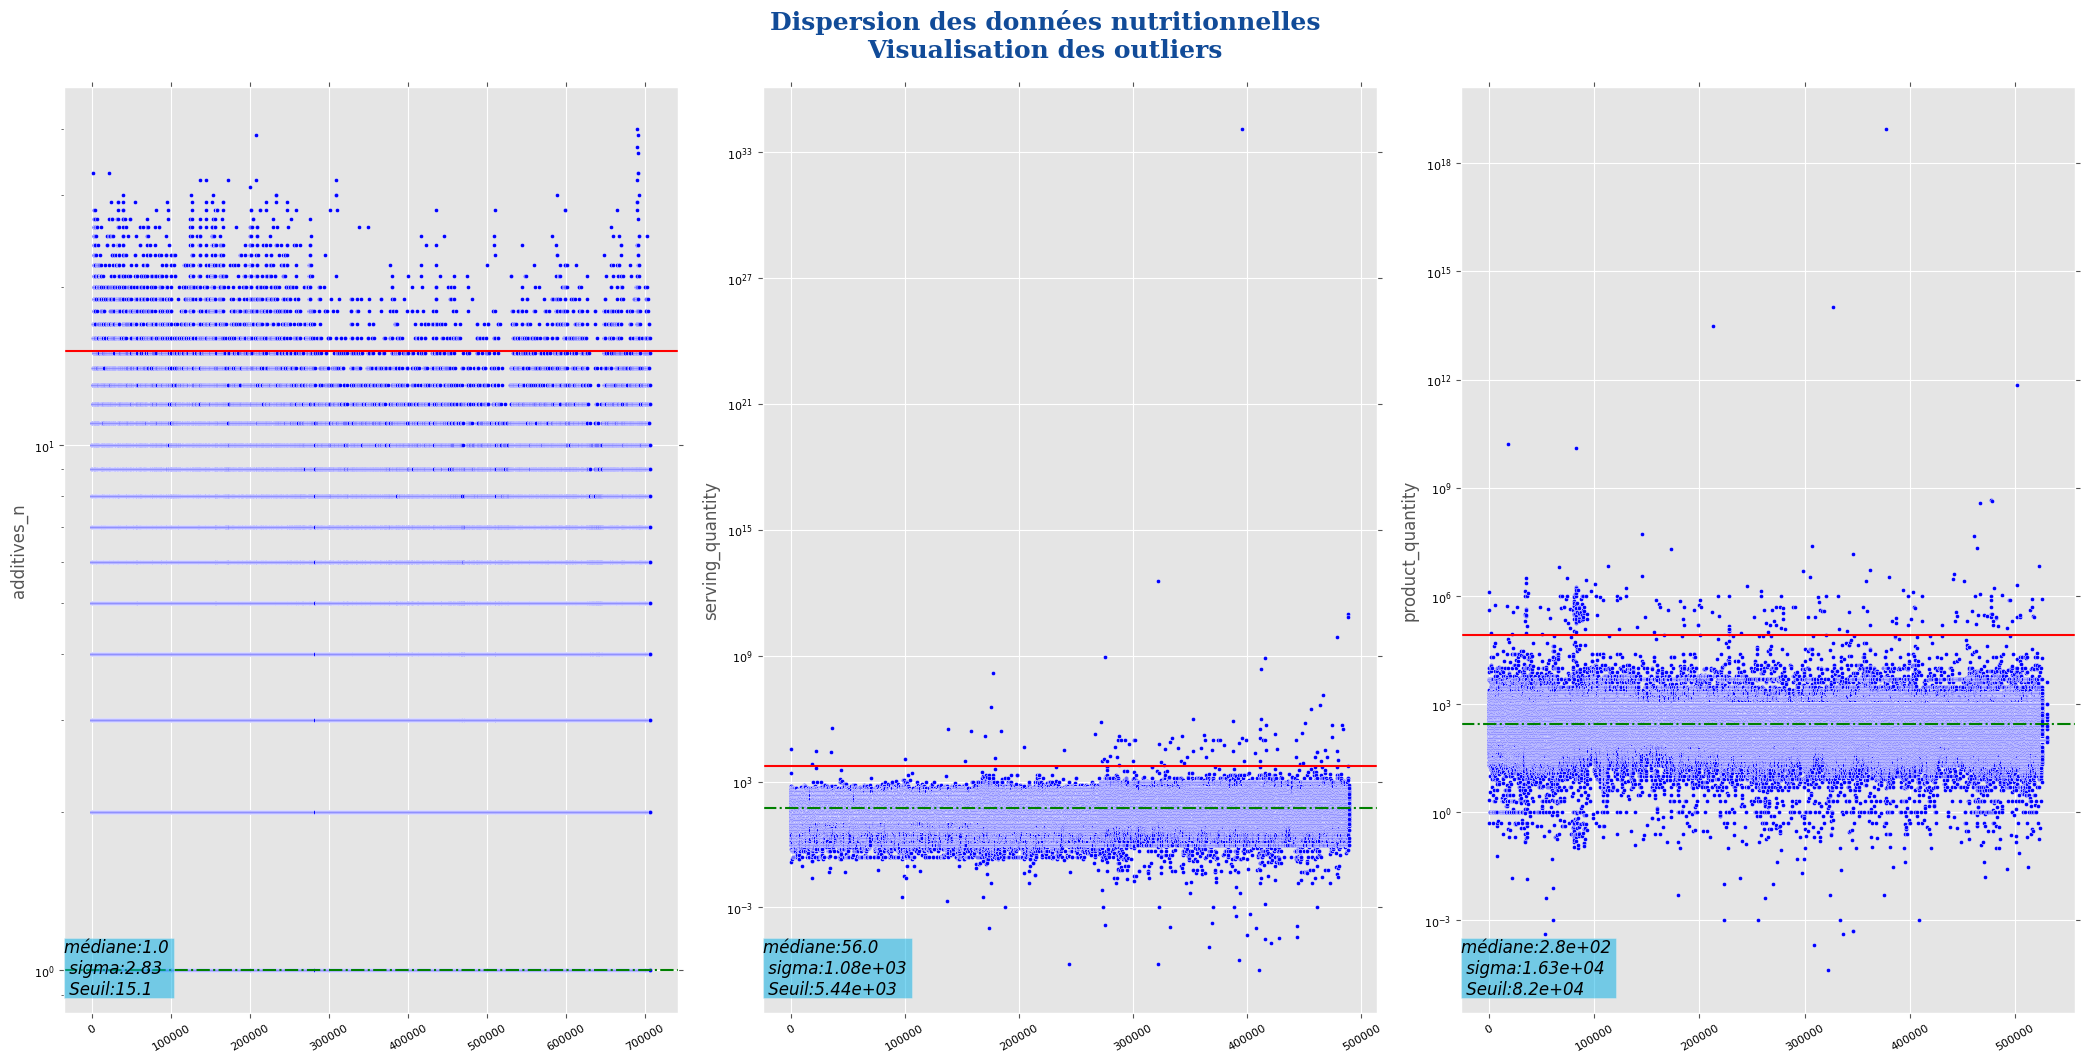

In [85]:
plt.style.use('ggplot')
tPlot, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize=(21,10))
axes = np.array(axes).flatten() # flatten pour avoir un tableau à 1 dimension

i = 0
for ax in axes:
    colonne = sigma_features[i]
    test = datas_cleaned[pd.notnull(datas_cleaned[colonne])][colonne]
    ax.tick_params(labelcolor='black',top='off',bottom='on',left='on',right='off',labelsize=8)
    ax.set_ylabel(colonne.rstrip("_100g"), fontsize = 12)
    ax.set_yscale("log")
    ax.plot(list(test), 'b.', markeredgewidth = 0.3, markeredgecolor='w')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.axhline(y=median[i], color='g', linestyle='dashdot')
    ax.axhline(y=median[i] + 5*sigma[i], color='r', linestyle='-')
    ax.text(0., 0.02, 'médiane:{:.3} \n sigma:{:.3} \n Seuil:{:.3}'.format(median[i], sigma[i], (median[i] + 5*sigma[i])),
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    i += 1

tPlot.text(0.5, 1.01, r"Dispersion des données nutritionnelles" "\n" "Visualisation des outliers", ha='center', fontdict=font_title)
plt.tight_layout()


Ces représentations nous indiquent clairement les éventuels **outliers qui diffèrent de la valeur médiane de plus de 5 fois l'écart-type ($5\sigma$ - valeur sélectionnée après plusieurs essais)**.

In [86]:
for i in range(len(sigma_features)):
    col = sigma_features[i]
    threshold = (median[i] + 5*sigma[i])
    print('{:30}: suppression de la ligne si valeur > {}'.format(col, round(threshold,3)))
    mask = datas_cleaned[col] > threshold
    datas_cleaned = datas_cleaned.drop(datas_cleaned[mask].index)

additives_n                   : suppression de la ligne si valeur > 15.135
serving_quantity              : suppression de la ligne si valeur > 5440.734
product_quantity              : suppression de la ligne si valeur > 82016.658


In [87]:
datas_cleaned.shape

(1833614, 165)

In [88]:
datas_cleaned.describe()

serving_quantity    additives_n  nutriscore_score     nova_group   
count     486211.000000  703938.000000     734092.000000  623917.000000  \
mean          97.958883       1.897791          9.163460       3.397840   
std          121.630429       2.602125          8.681766       0.982818   
min            0.000000       0.000000        -15.000000       1.000000   
25%           28.000000       0.000000          2.000000       3.000000   
50%           56.000000       1.000000         10.000000       4.000000   
75%          120.000000       3.000000         16.000000       4.000000   
max         5000.000000      15.000000         40.000000       4.000000   

       ecoscore_score  product_quantity  unique_scans_n  completeness   
count   462153.000000     529818.000000   632165.000000  1.833612e+06  \
mean        50.318007        425.707725        2.553188  4.804711e-01   
std         23.950378        928.416849        6.799259  2.015523e-01   
min          0.000000          0.000000        1.000000  2.000000e-01   
25%         33.000000        150.000000        1.000000  3.000000e-01   
50%         49.000000        280.000000        1.000000  4.000000e-01   
75%         72.000000        500.000000        2.000000  5.750000e-01   
max        125.000000      80000.000000      842.000000  1.100000e+00   

       energy-kj_100g  energy-kcal_100g  ...   
count   181932.000000      1.687334e+06  ...  \
mean      1083.295716      2.670431e+02  ...   
std        776.967728      1.850259e+02  ...   
min          0.000000      0.000000e+00  ...   
25%        394.000000      1.000000e+02  ...   
50%        992.000000      2.580000e+02  ...   
75%       1623.000000      3.980000e+02  ...   
max       3700.000000      9.000000e+02  ...   

       carbon-footprint-from-meat-or-fish_100g  nutrition-score-fr_100g   
count                             11263.000000            734095.000000  \
mean                                584.098751                 9.163487   
std                                6228.285065                 8.681761   
min                                   0.049000               -15.000000   
25%                                  99.900000                 2.000000   
50%                                 301.180000                10.000000   
75%                                 592.000000                16.000000   
max                              656298.600000                40.000000   

       nutrition-score-uk_100g  glycemic-index_100g  water-hardness_100g   
count                 2.000000             6.000000                1.000  \
mean                 15.500000            40.950000                1.475   
std                   3.535534            18.779111                  NaN   
min                  13.000000            14.000000                1.475   
25%                  14.250000            32.250000                1.475   
50%                  15.500000            41.500000                1.475   
75%                  16.750000            47.525000                1.475   
max                  18.000000            70.000000                1.475   

       choline_100g  phylloquinone_100g  beta-glucan_100g  inositol_100g   
count     92.000000         1332.000000         52.000000      76.000000  \
mean       0.211332            0.048006          3.506346       1.034707   
std        0.648491            1.450112          2.775687       8.598639   
min        0.000000            0.000000          0.400000       0.001600   
25%        0.032575            0.000008          2.275000       0.006400   
50%        0.073500            0.000024          3.600000       0.024000   
75%        0.116250            0.000103          4.000000       0.051000   
max        4.550000           51.600000         20.000000      75.000000   

       carnitine_100g  
count       45.000000  
mean         0.024716  
std          0.083990  
min          0.000800  
25%          0.007000  
50%          0.011000  
75%          0.015000  
ma

In [89]:
datas_cleaned.to_csv("datas_1_5.csv", sep='\t', encoding='utf-8', index=False)

Après ces quelques opérations de nettoyage, les valeurs médianes, d'écarts-type, de minimum et maximum sont plus cohérentes. Nous allons pouvoir exploiter ces données pour **estimer les valeurs manquantes**.

Nous allons déjà regarder la **distribution de ces variables et définir si elles suivent une loi normale**, ce qui nous aidera à prendre une décision pour la méthode d'imputation des valeurs manquantes.

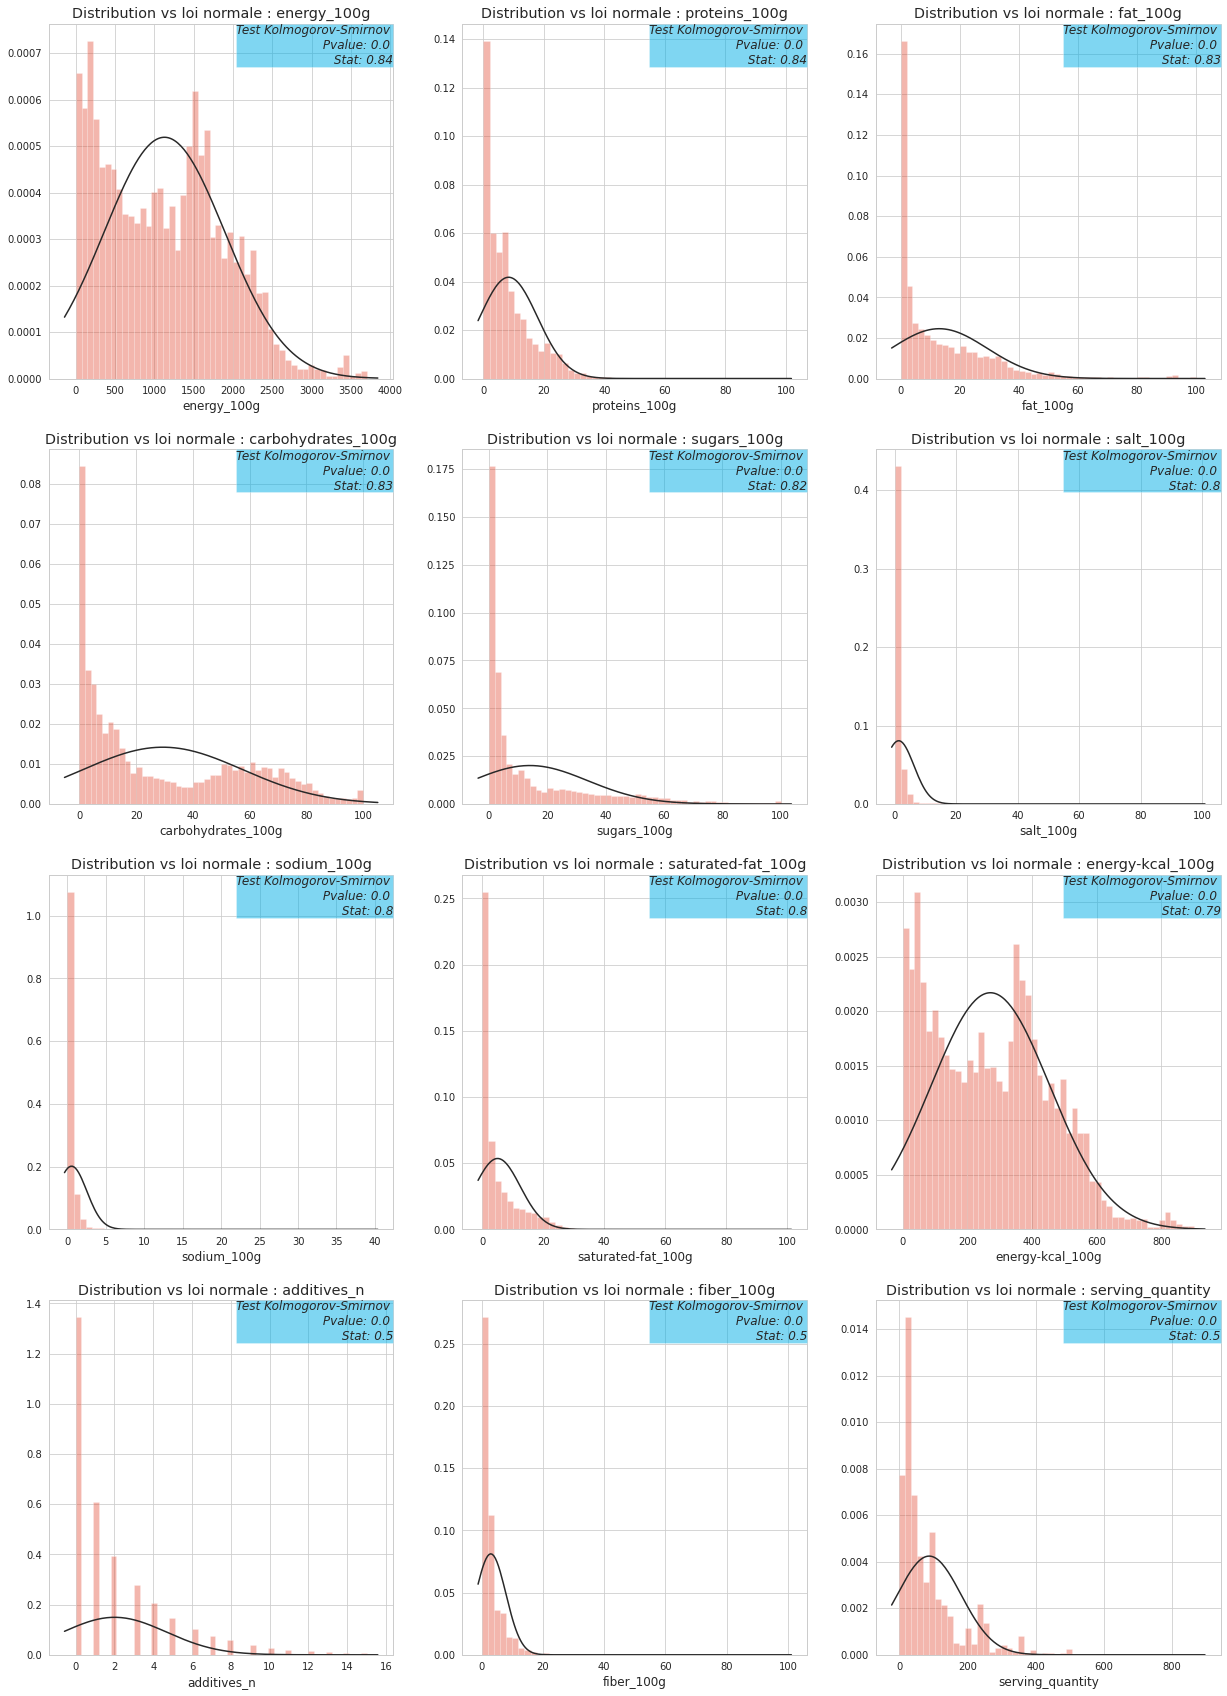

In [68]:
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,30))

sub = 0
for i in range(len(numerical_features)):
    fig.add_subplot(4,3,i+1)
    
    left, width = 0, 1
    bottom, height = 0, 1
    right = left + width
    top = bottom + height
    
    colonne = numerical_features[i]
    kstest = stats.kstest(datas_cleaned[colonne].notnull(),'norm')
    ax = sns.distplot(datas_cleaned[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    sub += 1
plt.show()

En se basant sur les projections obtenus et les résultats des tests de Kolmogorov-Smirnov (Pvalue < au niveau de test de 5%) **on rejette donc l'hypothèse de normalité des distributions de ces variables**. Il serait donc inexacte d'imputer les valeurs manquantes par la moyenne.

Pour confirmer cette approche, regardons à présent quelque unes de ces distributions en fonction de la catégorie `pnns_groups_1` :

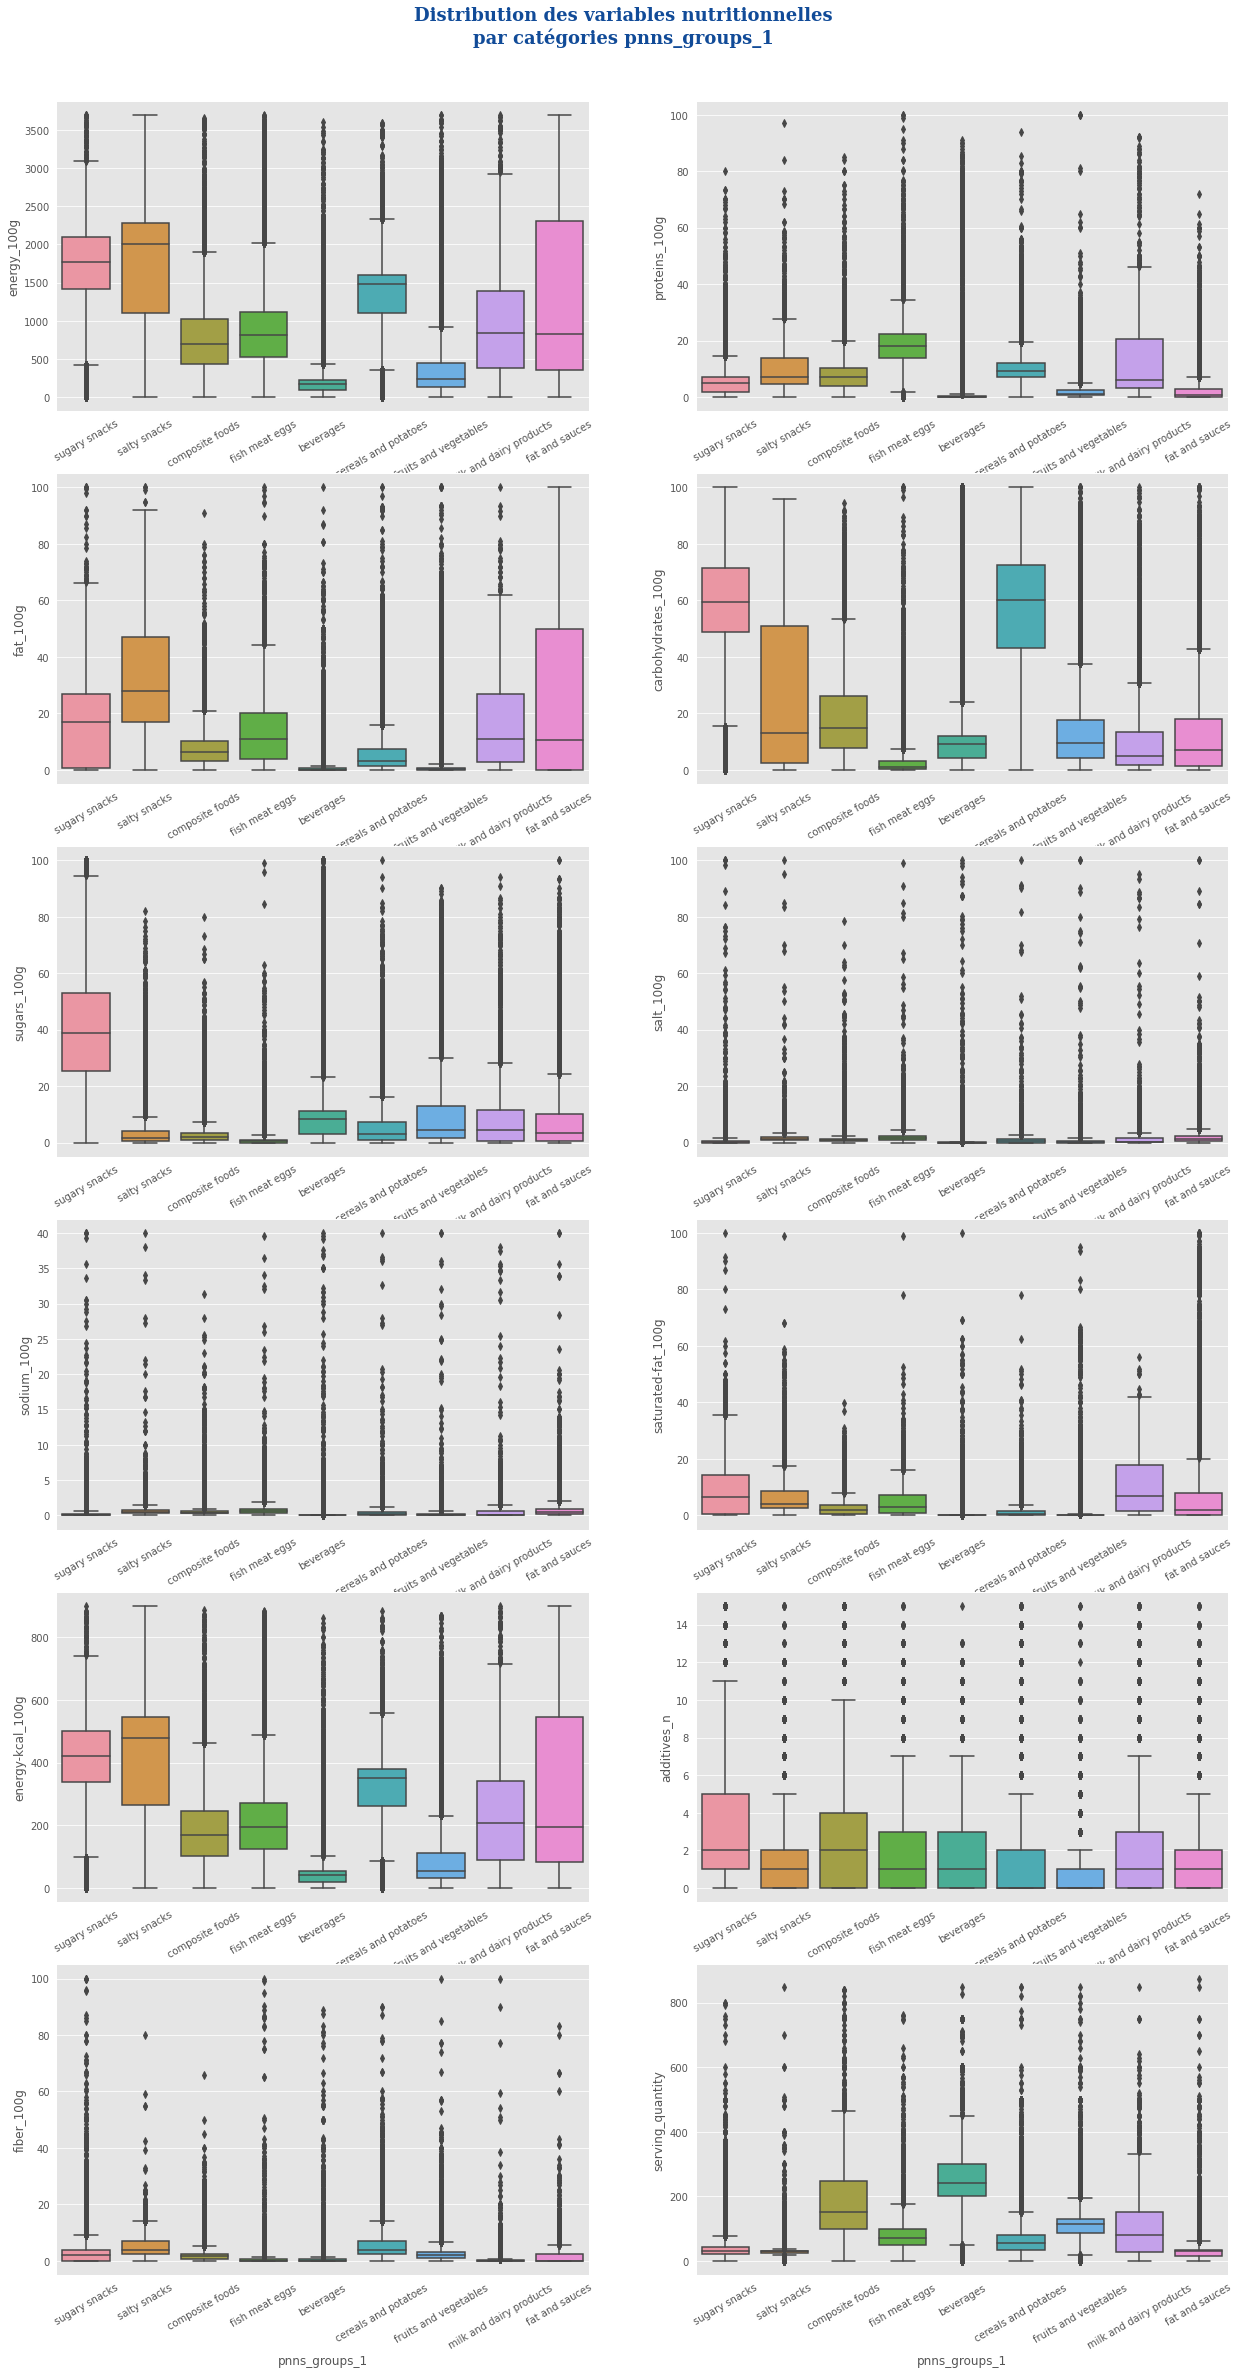

In [69]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,40))

sub = 0
for i in range(len(numerical_features)):
    fig.add_subplot(6,2,i+1)
    colonne = numerical_features[i]
    ax = sns.boxplot(x="pnns_groups_1", y=colonne, data=datas_cleaned[datas_cleaned["pnns_groups_1"]!="unknown"])
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_1", ha="center", 
         fontdict=font_title)
plt.show()

Si l'on regarde la distribution de quelques unes de ces mêmes variables sur la catégorie `pnns_groups_2` :

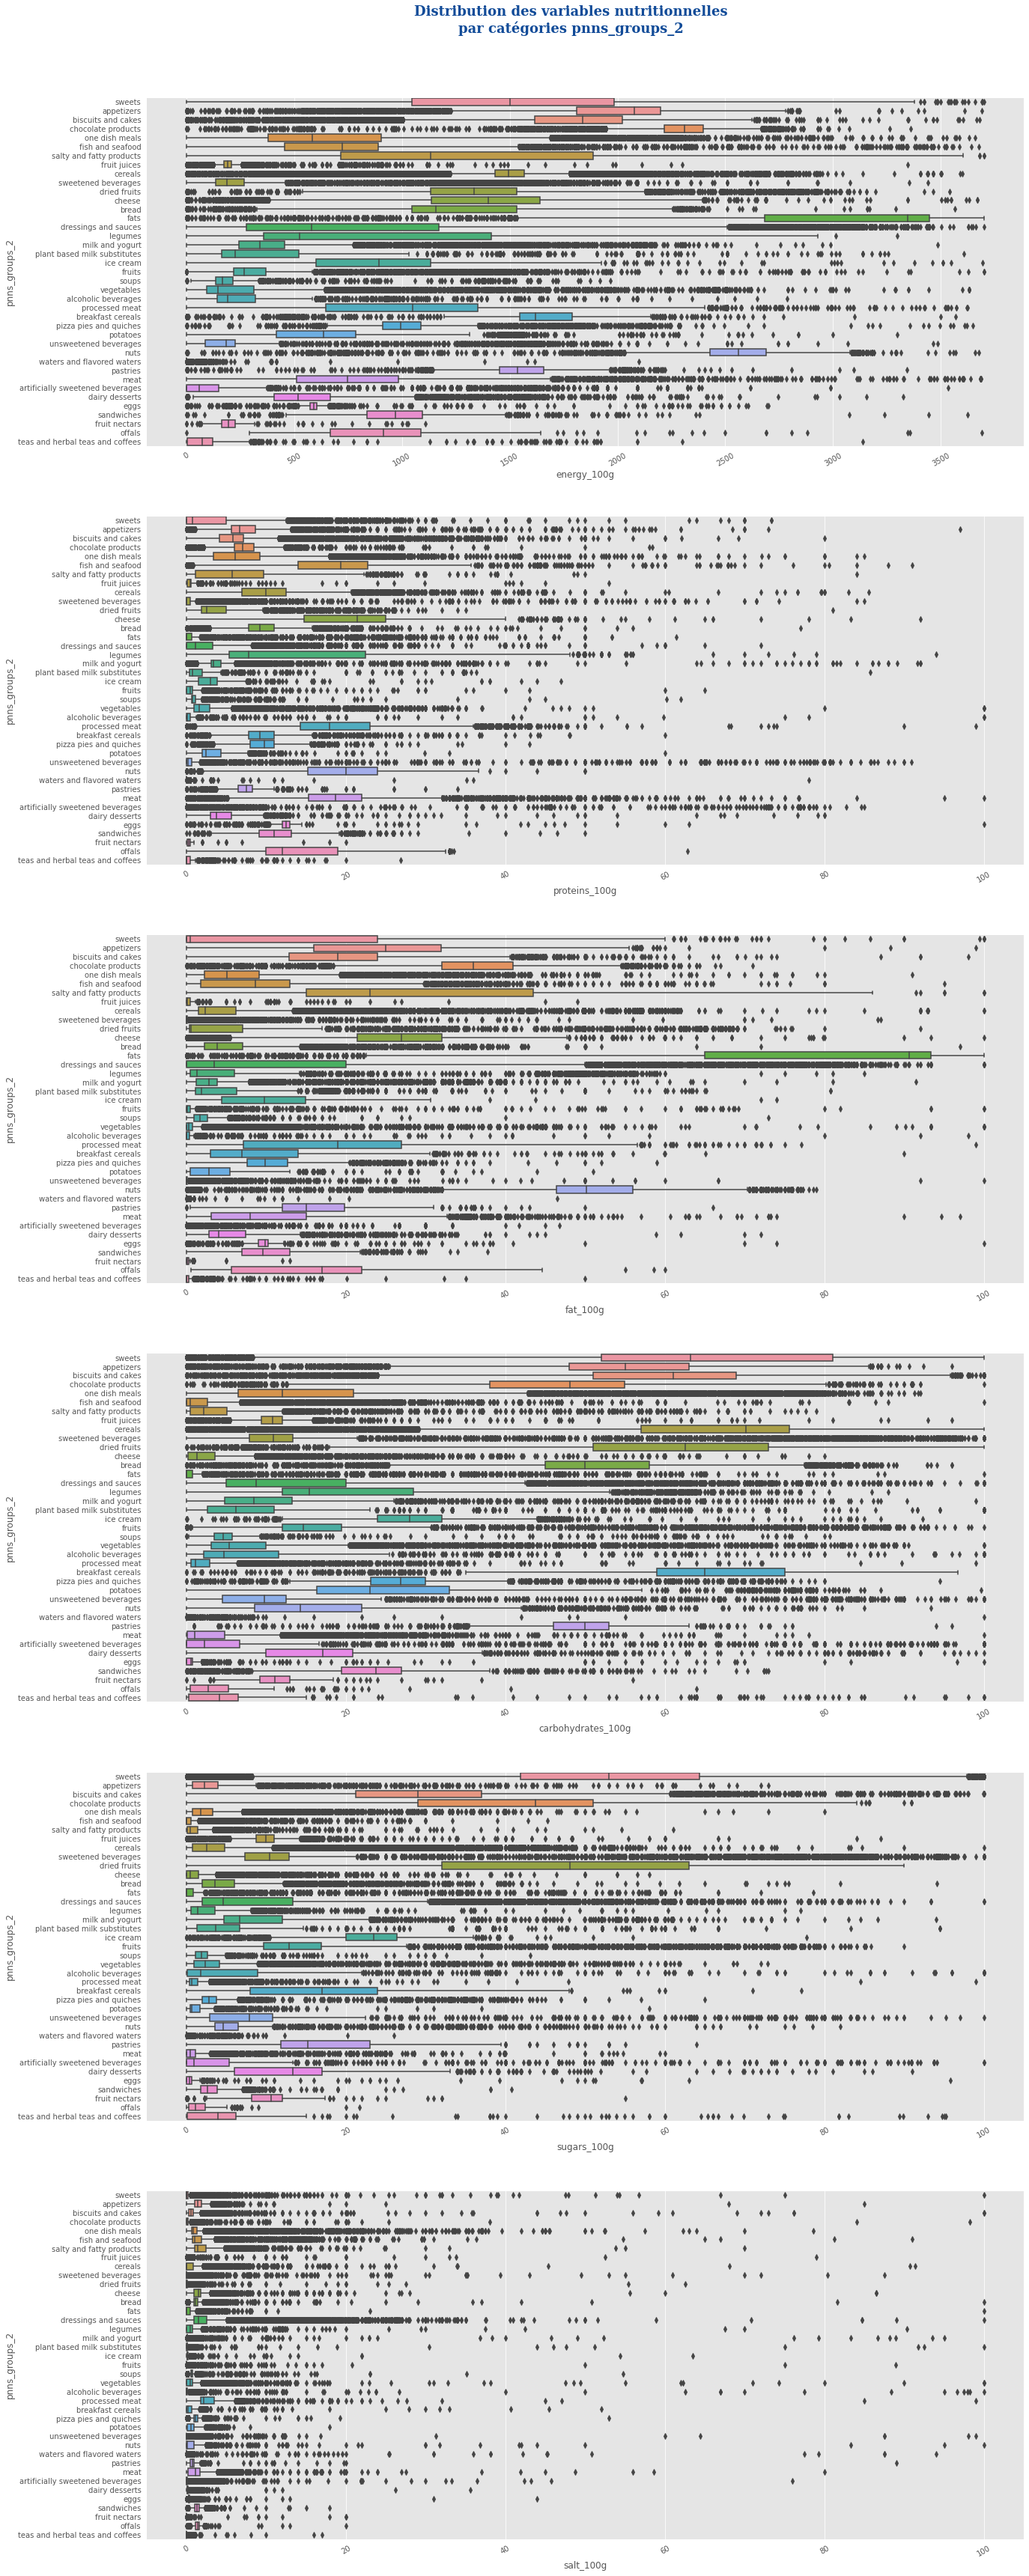

In [70]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,60))

sub = 0
for i in range(len(numerical_features[:6])):
    fig.add_subplot(6,1,i+1)
    colonne = numerical_features[i]
    ax = sns.boxplot(y="pnns_groups_2", x=colonne, data=datas_cleaned[datas_cleaned["pnns_groups_2"]!="unknown"])
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_2", ha="center", 
         fontdict=font_title)
plt.show()

In [71]:
datas_cleaned[numerical_features].isnull().sum()

energy_100g             4811
proteins_100g           6282
fat_100g                7336
carbohydrates_100g      7606
sugars_100g            24599
salt_100g              49366
sodium_100g            49370
saturated-fat_100g     46043
energy-kcal_100g       53976
additives_n           542775
fiber_100g            686156
serving_quantity      704534
dtype: int64

Pour ces valeurs nulles ci-dessus, les variables `serving_quantity` et `additives_n` sont très peu renseignées, nous allons donc les supprimer de notre jeu de données.     
`fiber_100g` est également mal renseigné mais nous en aurons besoin pour la suite. Nous allons donc compléter les valeurs nulles par la **médiane de la catégorie** `pnns_groups_2`.     
Enfin, pour les autres variables, avec peu de null et dont les distributions ne suivent pas la loi gaussiene, nous allons imputer avec l'**algorithme des K Nearest Neighbours** (KNN).

In [72]:
#On supprime les 2 colonnes les moins complétées et la variable redondante energie
datas_cleaned.drop(['serving_quantity','additives_n','energy-kcal_100g'], axis=1, inplace=True)

In [73]:
numerical_features.remove('serving_quantity')
numerical_features.remove('additives_n')
numerical_features.remove('energy-kcal_100g')

In [74]:
# KNN pour les autres variables
from sklearn.impute import KNNImputer

# On entraine le modèle d'imputation sur un échantillon de données
knn_features = ['energy_100g','proteins_100g','saturated-fat_100g','sugars_100g','salt_100g']
sample_datas = datas_cleaned[knn_features].sample(frac=0.25, random_state=1)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer.fit(sample_datas)

KNNImputer()

In [75]:
# Puis on applique le modèle sur l'ensemble des données
datas_imputed = imputer.transform(datas_cleaned[knn_features])
df_datas_imputed = pd.DataFrame(datas_imputed, columns=knn_features)

In [76]:
for col_knn in knn_features:
    datas_cleaned[col_knn] = df_datas_imputed[col_knn].values

In [77]:
# On complète les variables restantes avec la médiane du groupe pnns 2
for col in ['carbohydrates_100g','sodium_100g','fat_100g','fiber_100g']:
    datas_cleaned[col] = datas_cleaned.groupby('pnns_groups_2')[col].transform(lambda x: x.fillna(x.median()))

Les valeurs manquantes étant à présent toutes complétées pour ces variables numériques, nous allons vérifier que les distributions n'ont pas changées :

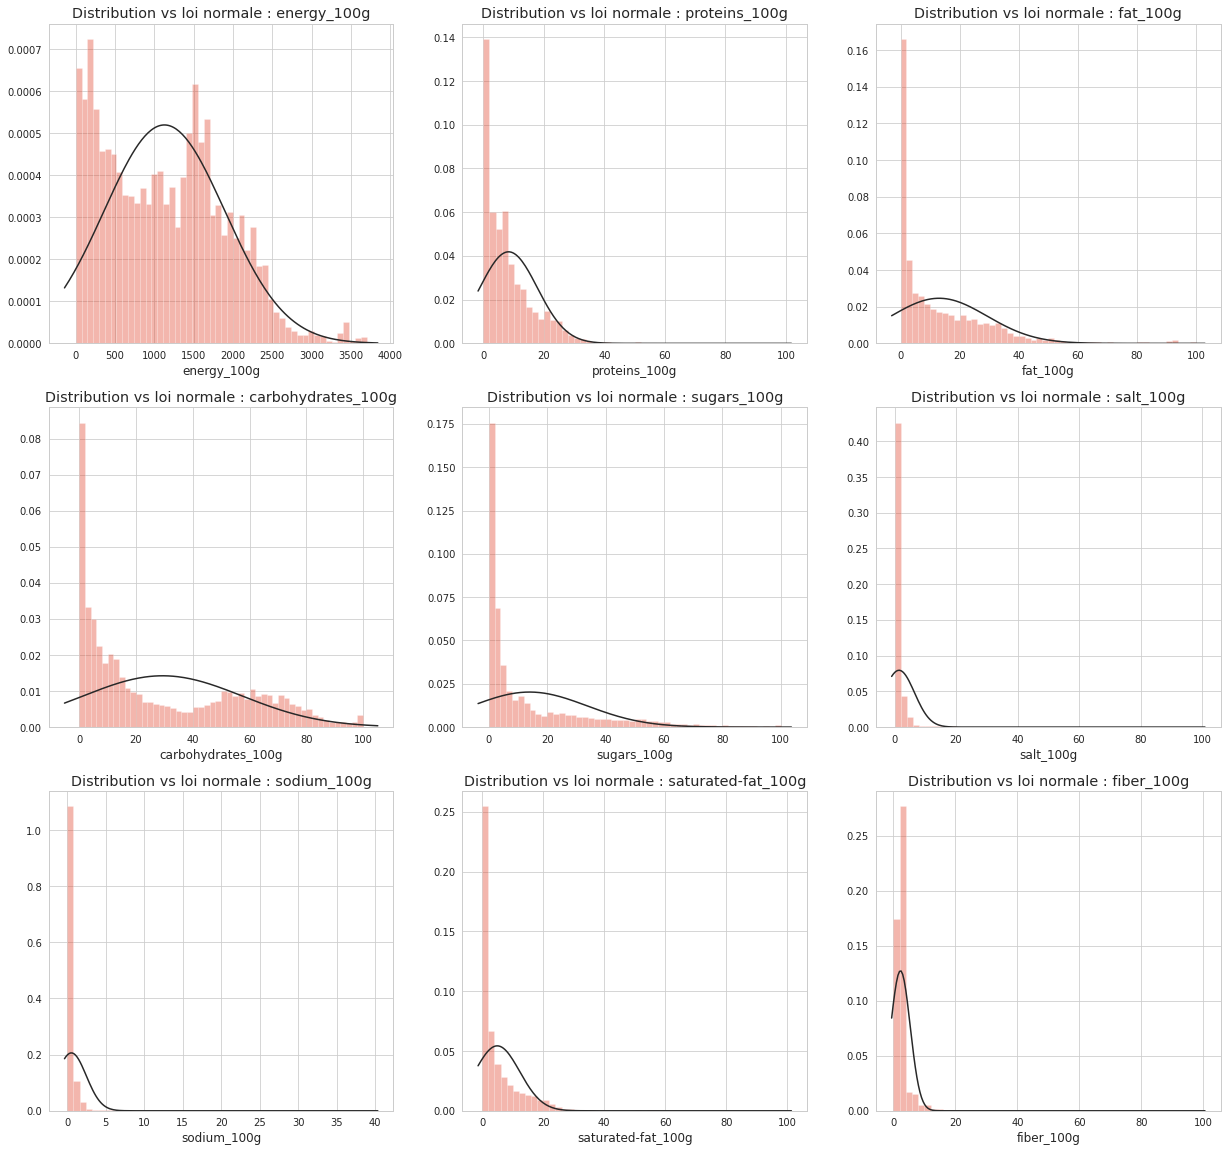

In [78]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,20))

sub = 0
for i in range(len(numerical_features)):
    fig.add_subplot(3,3,i+1)
    colonne = numerical_features[i]
    kstest = stats.kstest(datas_cleaned[colonne].notnull(),'norm')
    ax = sns.distplot(datas_cleaned[colonne], fit=stats.norm, kde=False)
    ax.set_title("Distribution vs loi normale : {}".format(colonne))
    sub += 1
plt.show()

Les variables imputées étant bien distribuées conformément aux variables d'origine, nous allons à présent **supprimer les dernières variables non pertinentes**, peu renseignées ou inutiles dans nos futurs modèles :

In [79]:
datas_cleaned.isnull().sum().sort_values(ascending=False)

quantity                                   765730
serving_size                               700569
image_ingredients_url                      611212
image_ingredients_small_url                611212
nova_group                                 604446
nutriscore_grade                           556150
nutriscore_score                           556150
nutrition-score-fr_100g                    556150
ingredients_text                           542775
ingredients_from_palm_oil_n                542775
ingredients_that_may_be_from_palm_oil_n    542775
image_nutrition_url                        467258
image_nutrition_small_url                  467258
brands                                     396301
image_small_url                            289551
image_url                                  289551
product_name                                 1431
creator                                         2
sodium_100g                                     0
url                                             0


In [80]:
deleted_features = ['brands','serving_size','nova_group','image_ingredients_small_url',
                    'image_ingredients_url','ingredients_text','ingredients_from_palm_oil_n',
                    'ingredients_that_may_be_from_palm_oil_n','image_nutrition_url','image_nutrition_small_url',
                    'image_url','image_small_url', 'nutrition-score-fr_100g','quantity']
datas_cleaned.drop(deleted_features, axis=1, inplace=True)

### <font color="#ea1c60" id="section_6">1.6. Calcul des Nutri-Scores manquants</font>

Une des variables primoridale de ce jeu de données est le Nutriscore. Or, cette variable compte beaucoup de manquants. 
Afin de calculer ce nutriscore, nous avons besoin de plusieurs autres variables.

Le score prend en comptepour 100g de produit, la teneur :
- En nutriments et aliments à favoriser (fibres, protéines, fruits et légumes),
- En nutriments à limiter (énergie, acide gras saturés, sucres, sel).

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.
Voici un tableau simplifié permettant de calculer l'attribution des points :

<table width="100%" style="border:solid 1px; text-align:center;" align="center">
    <thead style="border:solid 1px; text-align:center;">
        <th bgcolor="#feadb3"><b>Points</b></th>
        <th bgcolor="#feadb3">Energie (kJ)</th>
        <th bgcolor="#feadb3">Sucres simples (g)</th>
        <th bgcolor="#feadb3">Acide gras saturés (g)</th>
        <th bgcolor="#feadb3">Sodium (mg)</th>
        <th bgcolor="#b6faa3"><b>Points</b></th>
        <th bgcolor="#b6faa">Fruits,leg(%)</th>
        <th bgcolor="#b6faa">Fibres (g)</th>
        <th bgcolor="#b6faa">Protéines (g)</th>
    </thead>
    <tbody>
        <tr>
            <td bgcolor="#feadb3"><b>0</b></td>
            <td bgcolor="#feadb3">$\leq$ 335</td>
            <td bgcolor="#feadb3">$\leq$ 4,5</td>
            <td bgcolor="#feadb3">$\leq$ 1</td>
            <td bgcolor="#feadb3">$\leq$ 90</td>
            <td bgcolor="#b6faa"><b>0</b></td>
            <td bgcolor="#b6faa">$\leq$ 40</td>
            <td bgcolor="#b6faa">$\leq$ 0,7</td>
            <td bgcolor="#b6faa">$\leq$ 1,6</td>
        </tr>
        <tr>
            <td bgcolor="#feadb3"><b>5</b></td>
            <td bgcolor="#feadb3">$>$ 335</td>
            <td bgcolor="#feadb3">$>$ 4,5</td>
            <td bgcolor="#feadb3">$>$ 1</td>
            <td bgcolor="#feadb3">$>$ 90</td>
            <td bgcolor="#b6faa"><b>-2</b></td>
            <td bgcolor="#b6faa">$>$ 40</td>
            <td bgcolor="#b6faa">$>$ 0,7</td>
            <td bgcolor="#b6faa">$>$ 1,6</td>
        </tr>
        <tr>
            <td bgcolor="#feadb3"><b>10</b></td>
            <td bgcolor="#feadb3">$>$ 1675</td>
            <td bgcolor="#feadb3">$>$ 22,5</td>
            <td bgcolor="#feadb3">$>$ 5</td>
            <td bgcolor="#feadb3">$>$ 450</td>
            <td bgcolor="#b6faa"><b>-5</b></td>
            <td bgcolor="#b6faa">$>$ 80</td>
            <td bgcolor="#b6faa">$>$ 3,5</td>
            <td bgcolor="#b6faa">$>$ 8</td>
        </tr>
        <tr style="border:solid 1px; text-align:center;">
            <td> </td>
            <td>(a)</td>
            <td>(b)</td>
            <td>(c)</td>
            <td>(d)</td>
            <td> </td>
            <td>(e)</td>
            <td>(f)</td>
            <td>(g)</td>
        </tr>
        <tr>
            <td><b>Total</b></td>
            <td colspan="8"><b>(a) + (b) + (c) + (d) + (e) + (f) + (g)</b></td>
        </tr>
    </tbody>
</table>

Attribution des classes *(version simplifiée)* :

<table width="50%" style="border:solid 1px; text-align:center;" align="center">
    <thead>
        <th>Aliment solide</th>
        <th>Lettre</th>
        <th>Couleur</th>
    </thead>
    <tbody>
        <tr>
            <td>Mimimum -1</td>
            <td>A</td>
            <td>Vert foncé</td>
        </tr>
        <tr>
            <td>0 à 5</td>
            <td>B</td>
            <td>Vert</td>
        </tr>
        <tr>
            <td>5 à 10</td>
            <td>C</td>
            <td>Jaune</td>
        </tr>
        <tr>
            <td>10 à 20</td>
            <td>D</td>
            <td>Orange</td>
        </tr>
        <tr>
            <td>20 et plus</td>
            <td>E</td>
            <td>Orange foncé</td>
        </tr>
    </tbody>
</table>

Nous allons donc **isoler les variables nécessaires au calcul du Nutriscore et vérifier leur taux de remplissage** :

In [81]:
nutriscore_features = ['pnns_groups_1', 'pnns_groups_2', 'nutriscore_grade', 'nutriscore_score',
                       'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g', 'fiber_100g', 'proteins_100g']
datas_cleaned[nutriscore_features].sample(10)

pnns_groups_1    pnns_groups_2 nutriscore_grade  \
1244519                  unknown          unknown              NaN   
207142                   unknown          unknown                c   
1271553                  unknown          unknown              NaN   
880299   milk and dairy products           cheese                e   
1082962  milk and dairy products  milk and yogurt                e   
1090149            sugary snacks           sweets              NaN   
1055930            sugary snacks           sweets                d   
405979                   unknown          unknown                d   
604905     fruits and vegetables           fruits                a   
398762                   unknown          unknown              NaN   

         nutriscore_score  energy_100g  sugars_100g  saturated-fat_100g  \
1244519               NaN       1452.0         2.60                0.80   
207142               10.0        904.0         2.27                5.11   
1271553               NaN       1778.0        22.40                6.80   
880299               19.0       1669.0         1.50               18.00   
1082962              27.0       2351.0        41.20               16.10   
1090149               NaN        657.0         0.00                0.00   
1055930              14.0        293.0        70.00                0.10   
405979               14.0       1569.0        75.00                0.00   
604905               -3.0        280.0        12.90                0.01   
398762                NaN        335.0         2.00                0.00   

         sodium_100g  fiber_100g  proteins_100g  
1244519        0.104         2.1           6.90  
207142         0.420         1.1           6.82  
1271553        0.160         2.1           6.10  
880299         1.520         0.0          33.00  
1082962        0.120         0.0           9.10  
1090149        0.000         1.0           0.00  
1055930        0.400         1.0           0.50  
405979         0.000         0.0           0.00  
604905         0.004         1.5           0.70  
398762         0.150         2.1           2.00

La variable indiquant la proportion de fruit/légumes des produits a été supprimée car très peu renseignée. Nous allons donc tenter de l'estimer en fonction de la catégorie :

In [82]:
datas_cleaned.pnns_groups_2.unique()

array(['sweets', 'appetizers', 'biscuits and cakes', 'unknown',
       'chocolate products', 'one dish meals', 'fish and seafood',
       'salty and fatty products', 'fruit juices', 'cereals',
       'sweetened beverages', 'dried fruits', 'cheese', 'bread', 'fats',
       'dressings and sauces', 'legumes', 'milk and yogurt',
       'plant based milk substitutes', 'ice cream', 'fruits', 'soups',
       'vegetables', 'alcoholic beverages', 'processed meat',
       'breakfast cereals', 'pizza pies and quiches', 'potatoes',
       'unsweetened beverages', 'nuts', 'waters and flavored waters',
       'pastries', 'meat', 'artificially sweetened beverages',
       'dairy desserts', 'eggs', 'sandwiches', 'fruit nectars', 'offals',
       'teas and herbal teas and coffees'], dtype=object)

In [83]:
high_rate_fruit = ['fruit juices','dried fruits','legumes','vegetables','fruits', 'soups','potatoes','fruit nectars']

medium_rate_fruit = ['unknown', 'sweetened beverages', 'dressings and sauces', 'ice cream', 'pastries', 'dairy desserts',
                     'pizza pies and quiche', 'pizza pies and quiches']

low_rate_fruit = ['waters and flavored waters','chocolate products', 'fish and seafood', 'salty and fatty products', 
                  'cheese', 'cereals', 'appetizers', 'one dish meals', 'bread', 'fats', 'plant based milk substitutes',
                  'alcoholic beverages', 'processed meat', 'breakfast cereals', 'meat', 'eggs', 'sandwiches',
                  'offals', 'teas and herbal teas and coffees', 'biscuits and cakes', 'sweets', 'milk and yogurt',
                  'artificially sweetened beverages', 'unsweetened beverages','nuts']

In [84]:
datas_cleaned['fruits-vegetables-rate_100g'] = [81 if cat in high_rate_fruit else 45 if cat in medium_rate_fruit else 25 for cat in datas_cleaned.pnns_groups_2]

A présent, nous allons définir la **fonction de calcul du Nutriscore** et l'appliquer à notre dataset :

In [85]:
def calc_globalscore(row):
    #Energy
    if row["energy_100g"] <= 335:
        a = 0
    elif ((row["energy_100g"] > 335) & (row["energy_100g"] <= 1675)):
        a = 5
    else:
        a = 10 
    #Sugar
    if row["sugars_100g"] <= 4.5:
        b = 0
    elif ((row["sugars_100g"] > 4.5) & (row["sugars_100g"] <= 22.5)):
        b = 5
    else:
        b = 10
    #saturated-fat
    if row["saturated-fat_100g"] <= 1:
        c = 0
    elif ((row["saturated-fat_100g"] > 1) & (row["saturated-fat_100g"] <= 5)):
        c = 5
    else:
        c = 10
    #sodium
    if (row["sodium_100g"]/1000) <= 90:
        d = 0
    elif (((row["sodium_100g"]/1000) > 90) & ((row["sodium_100g"]/1000) <= 450)):
        d = 5
    else:
        d = 10
    #fruits-vegetables-rate
    if row["fruits-vegetables-rate_100g"] <= 40:
        e = 0
    elif ((row["fruits-vegetables-rate_100g"] > 40) & (row["fruits-vegetables-rate_100g"] <= 80)):
        e = -2
    else:
        e = -5
    #fiber
    if row["fiber_100g"] <= 0.7:
        f = 0
    elif ((row["fiber_100g"] > 0.7) & (row["fiber_100g"] <= 3.5)):
        f = -2
    else:
        f = -5
    #proteins
    if row["proteins_100g"] <= 1.6:
        g = 0
    elif ((row["proteins_100g"] > 1.6) & (row["proteins_100g"] <= 8)):
        g = -2
    else:
        g = -5
    
    #Global_score
    global_score = a+b+c+d+e+f+g
    
    return global_score

In [86]:
#Nutriscore
def calc_nutriscore(row):
    if row["calc_global_score"] < 0 :
        nutriscore = "a"
    elif ((row["calc_global_score"] >= 0) & (row["calc_global_score"] < 5)) :
        nutriscore = "b"
    elif ((row["calc_global_score"] >= 5) & (row["calc_global_score"] < 10)) :
        nutriscore = "c"
    elif ((row["calc_global_score"] >= 10) & (row["calc_global_score"] < 20)) :
        nutriscore = "d"
    else:
        nutriscore = "e"
        
    return nutriscore

In [87]:
datas_cleaned['calc_global_score'] = datas_cleaned.apply(lambda row: calc_globalscore(row),axis=1)
datas_cleaned['calc_nutriscore'] = datas_cleaned.apply(lambda row: calc_nutriscore(row),axis=1)

In [88]:
nutriscore_features.append('calc_global_score')
nutriscore_features.append('calc_nutriscore')

In [89]:
datas_cleaned[nutriscore_features].sample(10)

pnns_groups_1        pnns_groups_2 nutriscore_grade  \
264254                unknown              unknown              NaN   
716705                unknown              unknown              NaN   
794380                unknown              unknown              NaN   
689071          sugary snacks   biscuits and cakes                c   
118619              beverages  sweetened beverages              NaN   
1482876               unknown              unknown                e   
1383390               unknown              unknown              NaN   
38398    cereals and potatoes                bread                c   
709848        composite foods       one dish meals                b   
205546                unknown              unknown                c   

         nutriscore_score  energy_100g  sugars_100g  saturated-fat_100g  \
264254                NaN        183.0         1.05               0.100   
716705                NaN        100.0         5.00               0.000   
794380                NaN        941.0         1.20               8.400   
689071               10.0       1544.0        35.60               0.300   
118619                NaN        142.0         8.47               4.066   
1482876              26.0       2113.0        40.40              17.700   
1383390               NaN       1172.0         3.10               1.000   
38398                 3.0       1197.0        17.86               0.000   
709848                0.0        527.0         2.40               0.400   
205546                7.0       1088.0        20.00               0.000   

         sodium_100g  fiber_100g  proteins_100g  calc_global_score  \
264254         0.232         2.1           1.60                 -4   
716705         0.000         2.1           0.50                  1   
794380         0.760         2.1          14.70                  6   
689071         0.164         2.0           3.80                 11   
118619         0.004         0.0           0.00                  8   
1482876        0.120         2.1           6.30                 24   
1383390        0.760         2.1           7.90                 -1   
38398          0.375         3.6           7.14                  3   
709848         0.408         1.5          10.60                 -2   
205546         0.000         0.0           0.00                  8   

        calc_nutriscore  
264254                a  
716705                b  
794380                c  
689071                d  
118619                c  
1482876               e  
1383390               a  
38398                 b  
709848                a  
205546                c

Nous devons à présent **vérifier les erreurs d'imputation sur les scores déjà connus**, ce qui nous permettra de voir si les calculs sont satisfaisants et utilisables :

In [90]:
df_scores = datas_cleaned[['nutriscore_grade', 'nutriscore_score', 'calc_nutriscore', 'calc_global_score']][datas_cleaned['nutriscore_grade'].isnull()==False]

from sklearn.metrics import accuracy_score

accuracy_nutrigrade = accuracy_score(df_scores['nutriscore_grade'].values, df_scores['calc_nutriscore'].values)
print("L'accuracy_score sur les Nutrigrades calculés est de : {:.2f} %.".format(accuracy_nutrigrade*100))

L'accuracy_score sur les Nutrigrades calculés est de : 49.10 %.


La précision du calul est donc inférieure à 50%. **Ces calculs ne peuvent donc pas être utilisés pour compléter nos données**.     **<font color="green">Notre application aura donc pour but d'éstimer le nutrigrade d'un produit en fonction de ses caractéristiques connues, comme la catégorie, sa teneur en nutriments ... grâce à des algorithmes simples de Machine Learning</font>**. 

In [91]:
datas_cleaned.drop(['calc_nutriscore','calc_global_score'], axis=1, inplace=True)

In [92]:
datas_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1079102 entries, 943812 to 1114460
Data columns (total 24 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   code                         1079102 non-null  object        
 1   states_en                    1079102 non-null  object        
 2   url                          1079102 non-null  object        
 3   created_datetime             1079102 non-null  datetime64[ns]
 4   last_modified_datetime       1079102 non-null  datetime64[ns]
 5   creator                      1079100 non-null  object        
 6   pnns_groups_2                1079102 non-null  object        
 7   countries_en                 1079102 non-null  object        
 8   pnns_groups_1                1079102 non-null  object        
 9   product_name                 1077671 non-null  object        
 10  energy_100g                  1079102 non-null  float64       
 11  protei

Les variables sont à présent filtrées et les données nettoyées et complétées. Nous allons sauvegarder le dataset cleaned pour l'utiliser à présent dans nos **analyses exploratoires**.

In [93]:
datas_cleaned.set_index("code").to_csv("cleaned_openfoodfacts.csv", sep='\t')